In [1]:
%run imports_and_user_variables 50

Using TensorFlow backend.


Imports and variable definitions successful, using 50 files.


In [ ]:
# Load dataset
f = h5py.File(UNITS_FILE, 'r')
# Training data
train_units = f['units_train']
train_noisy_units = f['units_train_noisy']
# Testing data
test_units = f['units_test']
print("Train:", train_units.shape)
print("Noisy train:", train_noisy_units.shape)
print("Test:", test_units.shape)

## Timing for real-time performance

In [4]:
# Inspect a random input sample
sample_index = np.random.randint(len(test_units))
sample_input = test_units[sample_index].squeeze()

#### VAE

In [5]:
latent_dim = 50
epsilon_std = 1
MODEL_FILE = './models/vae_v9_encoder_latent50.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v9_decoder_latent50.h5'
decoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

In [13]:
%%time
num_samples = 1000

tic = time.time()
for i in range(num_samples):
    sample_output = decoder.predict(encoder.predict(sample_input[np.newaxis, ..., np.newaxis]))
toc = time.time()

time_per_prediction = (toc - tic) / num_samples
print(time_per_prediction)

0.00655478954315


#### KNN

In [2]:
latent_dim = 500
epsilon_std = 1.0

MODEL_FILE = './models/vae_v7_encoder.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v7_decoder.h5'
decoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

KNN_MODEL_FILENAME = "./models/vae_v7_unit_selector_knn.pkl"
knn_model, UNITS_FILE = sklearn.externals.joblib.load(KNN_MODEL_FILENAME)

In [7]:
%%time
num_samples = 1000

tic = time.time()
for i in range(num_samples):
    z = encoder.predict(sample_input[np.newaxis, ..., np.newaxis])
    knn_index = knn_model.kneighbors(z, return_distance = False)[0][0]
toc = time.time()

time_per_prediction = (toc - tic) / num_samples
print(time_per_prediction)

0.0420035159588


#### RNN Encoder-Decoder

##### Whole lotta boilerplate

In [6]:
MODEL_FILE = './models/end2end_RNNdecoder_v1_encoder.h5'
encoder_model = load_model(MODEL_FILE)

MODEL_FILE = './models/end2end_RNNdecoder_v1_decoder.h5'
decoder_model = load_model(MODEL_FILE)

In [8]:
from keras.utils import Sequence

class TimeseriesGeneratorThreeInputs_OneHotOutput(Sequence):
    """Keras data reading class
    Utility class for generating batches of temporal data.
    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.
    
    Adapted from the TimeseriesGenerator class:
    https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
    """

    def __init__(self, data1, data2, targets, length,
                 sampling_rate=1,
                 stride=1,
                 start_index=0,
                 end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=128):
        self.data1 = data1
        self.data2 = data2
        assert len(data1) == len(data2)
        self.targets = targets
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length
        if end_index is None:
            end_index = len(data1) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size

        if self.start_index > self.end_index:
            raise ValueError('`start_index+length=%i > end_index=%i` '
                             'is disallowed, as no part of the sequence '
                             'would be left to be used as current step.'
                             % (self.start_index, self.end_index))

    def __len__(self):
        return int(np.ceil(
            (self.end_index - self.start_index + 1) /
            (self.batch_size * self.stride)))

    def _empty_batch(self, num_rows):
        samples_shape = [num_rows, self.length // self.sampling_rate]
        samples_shape.extend(self.data1.shape[1:])
        targets_shape = [num_rows]
        targets_shape.extend(self.targets.shape[1:-1]) # Exclude the last channel dimension for OHE targets
        return np.empty(samples_shape), np.empty(samples_shape), np.empty(targets_shape), np.empty(targets_shape)

    def __getitem__(self, index):
        if self.shuffle:
            rows = np.random.randint(
                self.start_index, self.end_index + 1, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size *
                                    self.stride, self.end_index + 1), self.stride)

        samples1, samples2, targets_prev, targets = self._empty_batch(len(rows))
        for j, row in enumerate(rows):
            indices = range(rows[j] - self.length, rows[j], self.sampling_rate)
            samples1[j] = self.data1[indices]
            samples2[j] = self.data2[indices]
            
            # Change from (NUM_PITCHES, NUM_TICKS, 1) to (NUM_TICKS, NUM_PITCHES)
            assert len(targets.shape) == 3
            targets_prev[j] = self.targets[rows[j]].swapaxes(0,1).squeeze()
            targets[j,:-1,:] = targets_prev[j,1:,:] # Copy all columns shifted by one
            targets[j,-1,:] = targets_prev[j,-1,:] # Last column remains the same
        if self.reverse:
            return [samples1[:, ::-1, ...], samples2[:, ::-1, ...]], targets
        return [samples1, samples2, targets_prev], targets

In [9]:
# Load dataset
f = h5py.File(MONO_SEQ_FILE, 'r')
seq_units_input = f['input_test']
seq_units_comp = f['bass_test']
data_gen_train = TimeseriesGeneratorThreeInputs_OneHotOutput(f['input_train'], f['bass_train'], f['bass_train'], 
                                              length=WINDOW_LENGTH, sampling_rate=1, batch_size=128, shuffle=True)
data_gen_test = TimeseriesGeneratorThreeInputs_OneHotOutput(f['input_test'], f['bass_test'], f['bass_test'], 
                                              length=WINDOW_LENGTH, sampling_rate=1, batch_size=128, shuffle=True)
print(seq_units_input.shape)
print(seq_units_comp.shape)
print(len(data_gen_train))
print(len(data_gen_test))

(2538, 96, 96, 1)
(2538, 96, 96, 1)
186
19


In [10]:
num_decoder_tokens = NUM_PITCHES

def decode_sequence(input_seq_pair):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq_pair)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))

    # Populate the first character of target sequence with the start token.
    start_token = np.zeros(num_decoder_tokens)
    start_token[-1] = 1 # Start token is [...,0,0,0,1]
    target_seq[0, 0, :] = start_token

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    output_onehotmatrix = np.zeros((NUM_TICKS, num_decoder_tokens))
    output_onehotmatrix[0] = start_token
    for i in range(1,NUM_TICKS):
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = np.zeros(num_decoder_tokens)
        sampled_token[sampled_token_index] = 1 # One hot encoding
        # Write to output
        output_onehotmatrix[i] = sampled_token

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    assert np.all(np.sum(output_onehotmatrix, axis=1) == 1) # Each tick is a one-hot encoded vector
    output_pianoroll = pianoroll_utils.one_hot_to_pianoroll(output_onehotmatrix) 
    assert output_pianoroll.shape == (NUM_PITCHES, NUM_TICKS)
    return output_pianoroll

##### Timing

In [15]:
%%time

NUM_PREDICTIONS = 100
NUM_UNITS = WINDOW_LENGTH + NUM_PREDICTIONS
# Grab a random sequence of embeddings as input
unit_index = np.random.randint(seq_units_comp.shape[0] - NUM_UNITS)

# Predict NUM_PREDICTIONS embeddings
predicted_comp_units = np.zeros((WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS, 1)) #seq_units_comp[unit_index:unit_index + WINDOW_LENGTH].copy()

tic = time.time()

for i, _ in enumerate(range(NUM_PREDICTIONS)):
    input1 = np.array([
        seq_units_input[unit_index + i : unit_index + WINDOW_LENGTH + i]
    ])
    input2 = np.array([
        predicted_comp_units[-WINDOW_LENGTH:] # The WINDOW_LENGTH latest units
    ])
    # Predict new unit
#     y_comp = model.predict([input1,input2]) # Standard predictor
    y_comp = decode_sequence([input1,input2]) # RNN Decoder
    
    # Remove input pitches from the prediction
    input1_concat = np.concatenate(input1.squeeze(), axis=1)
    input_pitches = pianoroll_utils.get_active_pitches(input1_concat, MIN_PITCH, MAX_PITCH)
    y_comp = pianoroll_utils.mask_pitches(y_comp.squeeze(), input_pitches, MIN_PITCH, MAX_PITCH)
    y_comp = y_comp[np.newaxis, ..., np.newaxis]

    # Append predicted unit
    predicted_comp_units = np.concatenate([predicted_comp_units[1:], y_comp], axis=0)

# print(predicted_comp_units.shape)

toc = time.time()

time_per_prediction = (toc - tic) / NUM_PREDICTIONS
print(time_per_prediction)

0.157554299831
CPU times: user 24.5 s, sys: 2.33 s, total: 26.8 s
Wall time: 15.8 s


#### End-to-end ConvRNN

In [2]:
from keras.utils import Sequence

class TimeseriesGeneratorTwoInputs(Sequence):
    """Keras data reading class
    Utility class for generating batches of temporal data.
    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.
    
    Adapted from the TimeseriesGenerator class:
    https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
    """

    def __init__(self, data1, data2, targets, length,
                 sampling_rate=1,
                 stride=1,
                 start_index=0,
                 end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=128):
        self.data1 = data1
        self.data2 = data2
        assert len(data1) == len(data2)
        self.targets = targets
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length
        if end_index is None:
            end_index = len(data1) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size

        if self.start_index > self.end_index:
            raise ValueError('`start_index+length=%i > end_index=%i` '
                             'is disallowed, as no part of the sequence '
                             'would be left to be used as current step.'
                             % (self.start_index, self.end_index))

    def __len__(self):
        return int(np.ceil(
            (self.end_index - self.start_index + 1) /
            (self.batch_size * self.stride)))

    def _empty_batch(self, num_rows):
        samples_shape = [num_rows, self.length // self.sampling_rate]
        samples_shape.extend(self.data1.shape[1:])
        targets_shape = [num_rows]
        targets_shape.extend(self.targets.shape[1:])
        return np.empty(samples_shape), np.empty(samples_shape), np.empty(targets_shape)

    def __getitem__(self, index):
        if self.shuffle:
            rows = np.random.randint(
                self.start_index, self.end_index + 1, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size *
                                    self.stride, self.end_index + 1), self.stride)

        samples1, samples2, targets = self._empty_batch(len(rows))
        for j, row in enumerate(rows):
            indices = range(rows[j] - self.length, rows[j], self.sampling_rate)
            samples1[j] = self.data1[indices]
            samples2[j] = self.data2[indices]
            targets[j] = self.targets[rows[j]] # Comp
#             targets[j] = np.clip(self.data1[rows[j]] + self.data2[rows[j]], 0, 1) # Full
        if self.reverse:
            return [samples1[:, ::-1, ...], samples2[:, ::-1, ...]], targets
        return [samples1, samples2], targets

In [4]:
# Load dataset
f = h5py.File(SEQ_FILE, 'r')
seq_units_input = f['input_test']
seq_units_comp = f['comp_test']
# seq_embed_input = f['input_embed_test']
# seq_embed_comp = f['comp_embed_test']
data_gen_train = TimeseriesGeneratorTwoInputs(f['input_train'], f['comp_train'], f['comp_train'], 
                                              length=WINDOW_LENGTH, sampling_rate=1, batch_size=128, shuffle=True)
data_gen_test = TimeseriesGeneratorTwoInputs(f['input_test'], f['comp_test'], f['comp_test'], 
                                              length=WINDOW_LENGTH, sampling_rate=1, batch_size=128, shuffle=True)
print(seq_units_input.shape)
print(seq_units_comp.shape)
# print(seq_embed_input.shape)
# print(seq_embed_comp.shape)
print(len(data_gen_train))
print(len(data_gen_test))

(444, 96, 96, 1)
(444, 96, 96, 1)
67
3


In [6]:
MODEL_FILE = './models/end2end_v3.h5'
model = load_model(MODEL_FILE)

In [7]:
%%time

NUM_PREDICTIONS = 100
NUM_UNITS = WINDOW_LENGTH + NUM_PREDICTIONS
# Grab a random sequence of embeddings as input
unit_index = np.random.randint(seq_units_comp.shape[0] - NUM_UNITS)

# Predict NUM_PREDICTIONS embeddings
predicted_comp_units = np.zeros((WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS, 1)) #seq_units_comp[unit_index:unit_index + WINDOW_LENGTH].copy()

tic = time.time()

for i, _ in enumerate(range(NUM_PREDICTIONS)):
    input1 = np.array([
        seq_units_input[unit_index + i : unit_index + WINDOW_LENGTH + i]
    ])
    input2 = np.array([
        predicted_comp_units[-WINDOW_LENGTH:] # The WINDOW_LENGTH latest units
    ])
    # Predict new unit
    y_comp = model.predict([input1,input2]) # Standard predictor
#     y_comp = decode_sequence([input1,input2]) # RNN Decoder
    
    # Remove input pitches from the prediction
    input1_concat = np.concatenate(input1.squeeze(), axis=1)
    input_pitches = pianoroll_utils.get_active_pitches(input1_concat, MIN_PITCH, MAX_PITCH)
    y_comp = pianoroll_utils.mask_pitches(y_comp.squeeze(), input_pitches, MIN_PITCH, MAX_PITCH)
    y_comp = y_comp[np.newaxis, ..., np.newaxis]

    # Append predicted unit
    predicted_comp_units = np.concatenate([predicted_comp_units[1:], y_comp], axis=0)

# print(predicted_comp_units.shape)

toc = time.time()

time_per_prediction = (toc - tic) / NUM_PREDICTIONS
print(time_per_prediction)

0.0189752817154
CPU times: user 2.94 s, sys: 170 ms, total: 3.11 s
Wall time: 1.9 s


## Diagrams for report

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import rc
# rc('text', usetex=True)

#### Linear regression

In [102]:
np.random.rand(2,3)

array([[0.34707994, 0.19642798, 0.3106085 ],
       [0.00259575, 0.41568377, 0.02182424]])

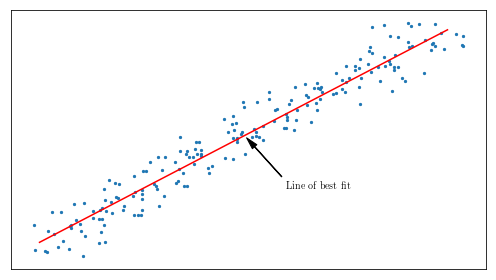

In [153]:
plt.figure(figsize=(7,4))
plt.tick_params(
    axis='both', # changes apply to the x-axis
    which='both', # both major and minor ticks are affected
    bottom=False, left=False,
    labelleft=False, labelbottom=False) # labels along the left and bottom edges are off

x = np.arange(0, 100, 0.5)
y = x*2
plt.plot(x, y, 'r')

x = x + 5*np.random.randn(x.shape[0])
y = y + 10*np.random.randn(y.shape[0])
plt.scatter(x, y, s=5)

plt.annotate('Line of best fit', 
             xy=(50,100),
             xytext=(60, 50),
             arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=6),)
plt.tight_layout()
plt.savefig('fig/linear_regression.eps', format='eps', dpi=1000)

#### Gradient descent

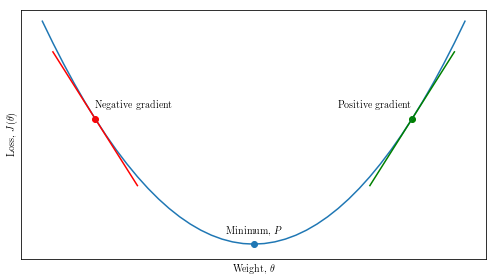

In [97]:
x = np.arange(-10, 10.5, 0.5)
y = x**2

plt.figure(figsize=(7,4))
plt.plot(x,y)
plt.ylabel(r'Loss, $J(\theta)$')
plt.xlabel(r'Weight, $\theta$')
plt.tick_params(
    axis='both', # changes apply to the x-axis
    which='both', # both major and minor ticks are affected
    bottom=False, left=False,
    labelleft=False, labelbottom=False) # labels along the left and bottom edges are off
plt.annotate(r'Minimum, $P$', 
             xy=(0,0),
             xytext=(0, 0+5),
             ha='center')
plt.scatter([0],[0])
plt.tight_layout()

# Draw gradients
grad_line_length = 2
grad_line_center = -7.5
negative_grad = ((grad_line_center+1)**2 - (grad_line_center-1)**2) / ((grad_line_center+1) - (grad_line_center-1))
x = np.array([grad_line_center - grad_line_length, grad_line_center + grad_line_length])
y = np.array([(grad_line_center)**2 - grad_line_length*negative_grad, (grad_line_center)**2 + grad_line_length*negative_grad])
plt.plot(x, y, color='r')
plt.scatter([grad_line_center], [grad_line_center**2], color='r')
plt.annotate('Negative gradient', 
             xy=(grad_line_center, grad_line_center**2),
             xytext=(grad_line_center, grad_line_center**2 + 5))

grad_line_center = 7.5
negative_grad = ((grad_line_center+1)**2 - (grad_line_center-1)**2) / ((grad_line_center+1) - (grad_line_center-1))
x = np.array([grad_line_center - grad_line_length, grad_line_center + grad_line_length])
y = np.array([(grad_line_center)**2 - grad_line_length*negative_grad, (grad_line_center)**2 + grad_line_length*negative_grad])
plt.plot(x, y, color='g')
plt.scatter([grad_line_center], [grad_line_center**2], color='g')
plt.annotate('Positive gradient', 
             xy=(grad_line_center, grad_line_center**2),
             xytext=(grad_line_center-3.5, grad_line_center**2 + 5))
plt.tight_layout()
plt.savefig('fig/gradient_descent_loss_function.eps', format='eps', dpi=1000)

#### Pianoroll matrix example

In [1]:
%run imports_and_user_variables 50

# Load dataset
f = h5py.File(UNITS_FILE, 'r')
# Training data
train_units = f['units_train']
train_noisy_units = f['units_train_noisy']
# Testing data
test_units = f['units_test']
print("Train:", train_units.shape)
print("Noisy train:", train_noisy_units.shape)
print("Test:", test_units.shape)

Using TensorFlow backend.


Imports and variable definitions successful, using 50 files.
('Train:', (4094, 96, 96, 1))
('Noisy train:', (4094, 96, 96, 1))
('Test:', (122, 96, 96, 1))


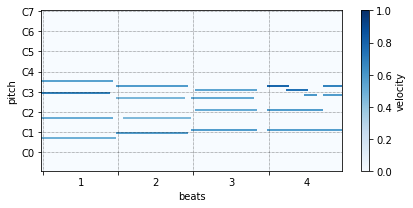

In [54]:
reload(pianoroll_utils)

fig, ax = plt.subplots()
fig.set_size_inches(6, 3, forward=True)

im = pianoroll_utils.plot_pianoroll(ax, train_units[2679].squeeze(), MIN_PITCH, MAX_PITCH, beat_resolution=24)
cax = fig.add_axes()
fig.colorbar(im, cax=cax, label='velocity')
plt.tight_layout()
plt.savefig('fig/pianoroll_matrix.eps', format='eps', dpi=1000)

#### Onsets matrix example

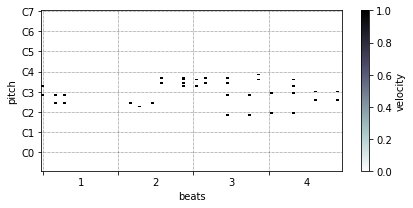

In [14]:
reload(pianoroll_utils)

fig, ax = plt.subplots()
fig.set_size_inches(6, 3, forward=True)

im = pianoroll_utils.plot_pianoroll(ax, train_units[12].squeeze(), MIN_PITCH, MAX_PITCH, cmap='bone_r')
cax = fig.add_axes()
fig.colorbar(im, cax=cax, label='velocity')
plt.tight_layout()
plt.savefig('fig/onsets_matrix.eps', format='eps', dpi=1000)

#### Onsets score-mask

In [2]:
%run imports_and_user_variables 50

Using TensorFlow backend.


Imports and variable definitions successful, using 50 files.


In [4]:
NUM_TICKS = 96    
# Score mask
beats_per_unit = 4
num_units = 1
ticks_per_beat = 24
sigma = 2
score_mask_row = -np.ones(NUM_TICKS) # Num ticks
for half_beat in range(2*beats_per_unit*num_units):
    hb = half_beat * ticks_per_beat / 2
    next_hb = hb + ticks_per_beat / 2
    # Good ticks
    score_mask_row[hb : hb + sigma + 1] = 1
    score_mask_row[next_hb - sigma : next_hb] = 1
    # Impartial ticks
    score_mask_row[hb + ticks_per_beat / 4] = 0
score_mask = np.zeros((1024, 96, NUM_TICKS))#K.int_shape(pianorolls_batch))
score_mask[:,:] = score_mask_row # Fill all rows
score_mask_example = score_mask[0]

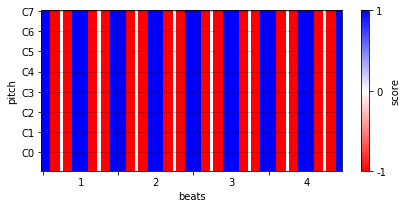

In [36]:
fig, ax = plt.subplots()

fig.set_size_inches(6, 3, forward=True)

im = pianoroll_utils.plot_pianoroll(ax, score_mask_example, MIN_PITCH, MAX_PITCH, beat_resolution=24)
im = ax.imshow(score_mask_example.astype('float32'), cmap='bwr_r', aspect='auto', 
          vmin=-1, vmax=1, origin='lower', interpolation='none')
cax = fig.add_axes()
cbar = fig.colorbar(im, cax=cax, label='score', ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['-1', '0', '1'])  # vertically oriented colorbar
plt.tight_layout()
plt.savefig('fig/onsets_score_mask.eps', format='eps', dpi=1000)

#### Custom loss function plateau

In [21]:
# loss, val_loss
csv_string = """11.7611,3.3207
2.234,1.6053
1.358,1.105
1.042,0.9836
0.9625,0.9243
0.9038,0.8761
0.8466,0.8124
0.794,0.7712
0.763,0.759
0.7572,0.7471
0.7522,0.7491
0.7517,0.7434
0.7487,0.7451
0.7545,0.7408
0.7567,0.7387
0.7512,0.7377
0.749,0.7362
0.7492,0.7414
0.7491,0.7341
0.746,0.7416
0.7476,0.7339
0.746,0.7318
0.7454,0.7338
0.7441,0.732
0.7456,0.7336
0.747,0.7418
0.7451,0.7305
0.7463,0.7322
0.7458,0.7343
0.7435,0.7328
0.7477,0.742
0.7455,0.7296
0.7452,0.7354
0.7444,0.7265
0.7459,0.7392
0.7472,0.7385
0.7442,0.7348
0.7458,0.7406
0.7486,0.7404
0.7479,0.7422
0.7467,0.732
0.7453,0.7347
0.7458,0.7359
0.7503,0.7472
0.7494,0.7348
0.7424,0.7286
0.7452,0.7386
0.7474,0.7353
0.7448,0.745
0.7439,0.725"""

import csv

lines = csv_string.splitlines()
reader = csv.reader(lines, delimiter=',')
losses = zip(*list(reader))
combined_loss = map(float, losses[0])
combined_val_loss = map(float, losses[1])

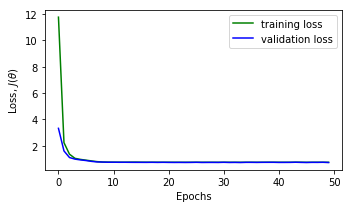

In [22]:
plt.figure(figsize=(5,3))
plt.plot(range(50), combined_loss, color='g', label='training loss')
plt.plot(range(50), combined_val_loss, color='b', label='validation loss')
plt.ylabel(r'Loss, $J(\theta)$')
plt.xlabel('Epochs')

plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('fig/losses_autoencoder_plateau_lossplot.eps', format='eps', dpi=1000)

#### Dense end-to-end overfit

In [18]:
# loss, val_loss
csv_string = """0.0163,0.0148
0.0136,0.0117
0.0103,0.0115
0.0089,0.0117
0.008,0.0118
0.0074,0.0118
0.007,0.0119
0.0066,0.0121
0.0063,0.012
0.006,0.0121"""

import csv

lines = csv_string.splitlines()
reader = csv.reader(lines, delimiter=',')
losses = zip(*list(reader))
combined_loss = map(float, losses[0])
combined_val_loss = map(float, losses[1])

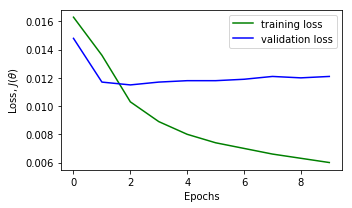

In [19]:
plt.figure(figsize=(5,3))
plt.plot(range(10), combined_loss, color='g', label='training loss')
plt.plot(range(10), combined_val_loss, color='b', label='validation loss')
plt.ylabel(r'Loss, $J(\theta)$')
plt.xlabel('Epochs')

plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('fig/end2end_dense_overfit_lossplot.eps', format='eps', dpi=1000)

#### Latent variable RNN overfit

In [8]:
# loss, val_loss
csv_string = """0.5571,0.5323
0.5254,0.5345
0.509,0.5301
0.4975,0.5325
0.4884,0.5318
0.4801,0.5343
0.4726,0.5377
0.4666,0.5393
0.4612,0.5398
0.4549,0.5434"""

import csv

lines = csv_string.splitlines()
reader = csv.reader(lines, delimiter=',')
losses = zip(*list(reader))
combined_loss = map(float, losses[0])
combined_val_loss = map(float, losses[1])

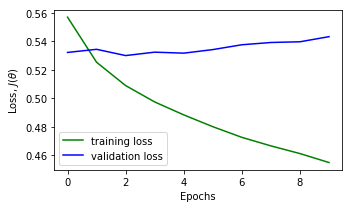

In [12]:
plt.figure(figsize=(5,3))
plt.plot(range(10), combined_loss, color='g', label='training loss')
plt.plot(range(10), combined_val_loss, color='b', label='validation loss')
plt.ylabel(r'Loss, $J(\theta)$')
plt.xlabel('Epochs')

plt.legend(loc='lower left')

plt.tight_layout()
plt.savefig('fig/latent_variable_rnn_overfit_lossplot.eps', format='eps', dpi=1000)

#### The smoothness problem, illustrated

In [5]:
MODEL_AUTOENCODER_FILE = './models/autoencoder_v4.h5'
autoencoder = load_model(MODEL_AUTOENCODER_FILE)

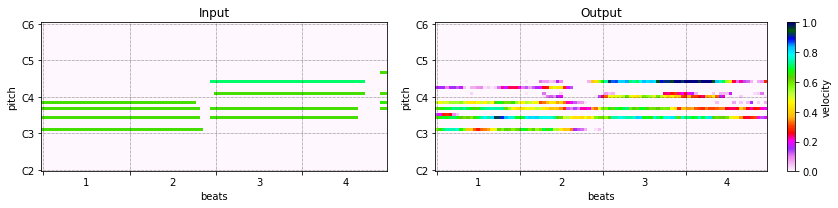

In [66]:
reload(pianoroll_utils)
input_unit = pianoroll_utils.pad_pianoroll(test_units[42].squeeze(), MIN_PITCH, MAX_PITCH)
# Get encoding of the input
output_unit = autoencoder.predict(input_unit[np.newaxis, ..., np.newaxis])

# Crop to zoom
min_pitch = 48
max_pitch = 96
input_pianoroll = pianoroll_utils.crop_pianoroll(input_unit, min_pitch, max_pitch)
output_pianoroll = pianoroll_utils.crop_pianoroll(output_unit.squeeze(), min_pitch, max_pitch)

# Plot comparison
fig, ax = plt.subplots(1,2, gridspec_kw = {'width_ratios':[5, 6]})
fig.set_size_inches(12, 3, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Output')
pianoroll_utils.plot_pianoroll(ax[0], input_pianoroll.squeeze(), min_pitch, max_pitch, cmap='gist_ncar_r')
im = pianoroll_utils.plot_pianoroll(ax[1], output_pianoroll.squeeze(), min_pitch, max_pitch, cmap='gist_ncar_r')

fig.colorbar(im, use_gridspec=True, label='velocity')

fig.tight_layout()
plt.savefig('fig/smoothness_problem.eps', format='eps', dpi=1000)

# pianoroll_utils.playPianoroll(sample_input)
# pianoroll_utils.playPianoroll(sample_output)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  3.4705973  20.77994    24.45203     0.877367    0.          3.9844081
  6.5914383   5.171249    1.4545087   2.5562441   3.8582234   0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.03607762  9.261589   13.108125   16.930813   20.213509   17.428322
 17.123474    3.6582694   3.8401468   0.          0.          0.90885544
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.

0

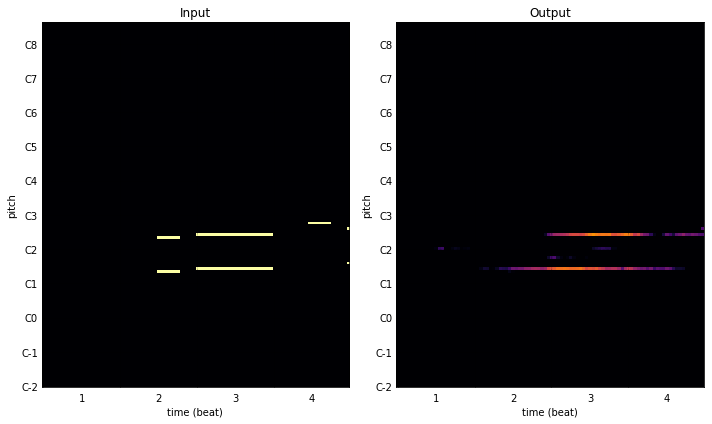

#### Jupyter environment

-### Jupyter notebook example
This is an example of how narration, live code, diagrams and _even audio components_ can come together in the [Jupyter environment](http://jupyter.org/).

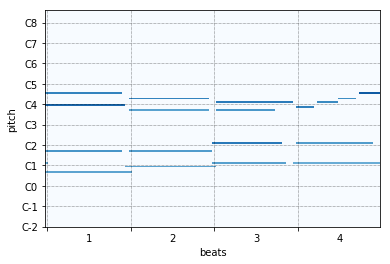

In [38]:
sample_pianoroll_unit = pianoroll_utils.pad_pianoroll(train_units[2713].squeeze(), MIN_PITCH, MAX_PITCH)

import pianoroll_utils
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

pianoroll_utils.plot_pianoroll(ax, sample_pianoroll_unit)
pianoroll_utils.play_pianoroll(sample_pianoroll_unit)

## GPU verification

In [1]:
# Test GPU on machine
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

/home/chanjunshern/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[[22. 28.]
 [49. 64.]]


## Custom metrics for musical correctness

~~Testing framework borrowed from [indraforyou's StackOverflow answer](https://stackoverflow.com/questions/33859864/how-to-create-custom-objective-function-in-keras).~~ Not anymore.

Arguments for using musical knowledge-informed metrics in the training loss: A 'perfect' AI would not be able to learn music all on its own, unless it knows how to appreciate what sounds good and what doesn't.

What are some desirable metrics?
1. Pitch IOU
2. Beat-respecting note onsets
3. Smoothness of continuous notes
4. Similarity of note onsets

#### Imports and user variables

In [1]:
%run imports_and_user_variables 50

# Load dataset
f = h5py.File(UNITS_FILE, 'r')
# Training data
train_units = f['units_train']
train_noisy_units = f['units_train_noisy']
# Testing data
test_units = f['units_test']
print("Train:", train_units.shape)
print("Noisy train:", train_noisy_units.shape)
print("Test:", test_units.shape)

Using TensorFlow backend.


Imports and variable definitions successful, using 50 files.
('Train:', (4094, 96, 96, 1))
('Noisy train:', (4094, 96, 96, 1))
('Test:', (122, 96, 96, 1))


#### Pitch intersection over union

In [74]:
def get_active_pitches(pianoroll, min_pitch=0, max_pitch=127):
    """
    Given a pianoroll matrix, return a list of all pitches that 
    were played in this pianoroll.
    """
    assert pianoroll.shape[0] == max_pitch - min_pitch + 1
    num_pitches = pianoroll.shape[0]
    
    pitches = np.arange(num_pitches) + min_pitch
    active_pitch_rows = np.any(pianoroll, axis=1) # List of booleans
    active_pitches = pitches[active_pitch_rows]
    return active_pitches

def get_active_pitch_classes(pianoroll, min_pitch=0, max_pitch=127):
    """
    Given a pianoroll matrix, return a list of all pitch classes
    (0-11 from C-B) that were played in this pianoroll.
    """
    active_pitches = get_active_pitches(pianoroll, min_pitch, max_pitch)
    active_pitch_classes = np.unique(active_pitches % 12)
    return active_pitch_classes

def pitch_intersection_over_union(pianoroll_1, pianoroll_2, min_pitch=0, max_pitch=127):
    """
    Given two pianoroll matrices, return the intersection over union
    of their active pitch classes (ignoring octaves)
    """
    assert pianoroll_1.shape[0] == max_pitch - min_pitch + 1
    assert pianoroll_2.shape[0] == max_pitch - min_pitch + 1
    
    notes_1 = set(get_active_pitch_classes(pianoroll_1, min_pitch, max_pitch))
    notes_2 = set(get_active_pitch_classes(pianoroll_2, min_pitch, max_pitch))
    
    intersection = notes_1.intersection(notes_2)
    union = notes_1.union(notes_2)
    if len(union) > 0:
        return float(len(intersection)) / len(union)
    else:
        return 0

In [76]:
reload(custom_loss)
MIN_PITCH = 13 # Pianoroll is cropped to start at MIDI note number 13 instead of 0
MAX_PITCH = 108 # Pianoroll is cropped to end at MIDI note number 108 instead of 127
NUM_PITCHES = MAX_PITCH - MIN_PITCH + 1
NUM_TICKS = 96

proll1 = np.zeros((NUM_PITCHES, NUM_TICKS))
proll1[60-MIN_PITCH] = 1 # tonic
proll1[64-MIN_PITCH] = 1 # major 3rd
proll1[67-MIN_PITCH] = 1 # perfect 5th

proll2 = proll1.copy()
proll2[71-MIN_PITCH] = 1 # 7th note
proll2[72-MIN_PITCH] = 1 # Tonic duplicate, doesn't count

pianorolls_batch_true = np.array([proll1, proll2])#, proll1, proll2])
pianorolls_batch_pred = np.array([proll2, proll1])#, proll1, proll2])

print(pitch_intersection_over_union(proll1, proll2, MIN_PITCH, MAX_PITCH))
print(K.eval(custom_loss.pitch_intersection_over_union_keras(pianorolls_batch_true, pianorolls_batch_pred)))


0.75
0.75


#### Onset quality

In general, we prefer notes that start at particular beat-divisions. Most common would be 1/1 beats, then 1/2 beats, then 1/4 beats, and so on. 

Being slightly off these beats by a tick or two is acceptable (even desirable for a less robotic musical performance), but in general we want to encourage note onsets close to these common beat-divisions. 

Therefore, we can use a metric that imposes
- Reward for onsets occuring at 1/2-beat marks (ie. at 24-tick resolution, occuring at 0, 11, 23... )
    - Also reward onsets at +/- sigma from those marks, for imperceivable timing inaccuracies
- Impartial to onsets occuring at 1/4-beat marks
- Penalizes onsets occuring at all other ticks

The formula is then: `num_good - num_bad / num_onsets`

\* *Assume 24-tick beats in all the following analyses*

In [329]:
def score_note_onsets(pianoroll, min_pitch=0, max_pitch=127, sigma=2, beats_per_unit=4, num_units=1):
    """
    Reward for onsets occuring at 1/2-beat marks (ie. at 24-tick resolution, occuring at 0, 11, 23... )
    Also reward onsets at +/- sigma from those marks, for imperceivable timing inaccuracies
    Impartial to onsets occuring at 1/4-beat marks
    Penalizes onsets occuring at all other ticks
    """
    ticks_per_beat = 24
    assert pianoroll.shape[1] == ticks_per_beat * beats_per_unit * num_units

    # Score mask
    score_mask_row = -np.ones(pianoroll.shape[1])
    for half_beat in range(2*beats_per_unit*num_units):
        hb = half_beat * ticks_per_beat / 2
        next_hb = hb + ticks_per_beat / 2
        # Good ticks
        score_mask_row[hb : hb + sigma + 1] = 1
        score_mask_row[next_hb - sigma : next_hb] = 1
        # Impartial ticks
        score_mask_row[hb + ticks_per_beat / 4] = 0
    score_mask = np.zeros(pianoroll.shape)
    score_mask[:] = score_mask_row # Fill all rows

    # Get note onset matrix
    note_onsets = get_note_onsets(pianoroll, min_pitch, max_pitch)
    
    # Calculate score
    if np.sum(note_onsets) != 0:
        score = np.sum(np.multiply(score_mask, note_onsets)) / np.sum(note_onsets)
        return score
    else:
        return 0

def get_note_onsets(pianoroll, min_pitch=0, max_pitch=127):
    """
    Takes an input pianoroll of shape (NUM_PITCHES, NUM_TICKS)
    and returns a list of tick-indices for all note-on events 
    for each pitch, as a list of lists.
    """
    assert pianoroll.shape[0] == max_pitch - min_pitch + 1
    num_pitches = pianoroll.shape[0]

    binarized = pianoroll.astype(bool)
    padded = np.pad(binarized, ((0, 0), (1, 1)), 'constant')
    diff = np.diff(padded.astype(int), axis=1)
    note_ons = np.array(diff > 0)[:,:-1] # Discard last column

    assert note_ons.shape == pianoroll.shape
    return note_ons


In [4]:
reload(custom_loss)
SIGMA = 2 # Accept 2 ticks of inaccuracy in each direction

# Pianoroll A
a = np.zeros((128,96))
a[60,:24] = 1
a[62,24:48] = 1
a[64,48:72] = 1
a[65,72:] = 1

# Pianoroll B
b = a.copy()
b[62,:] = 0
b[62,36:48] = 1 # Swing the note by half a beat

pianorolls_batch = np.array([a,b])
pianorolls_batch = pianorolls_batch[..., np.newaxis]
# print(pianoroll_utils.score_note_onsets(a, sigma=SIGMA))
# print(pianoroll_utils.score_note_onsets(b, sigma=SIGMA))

# pianorolls_batch = K.squeeze(pianorolls_batch, axis=3)
# print(K.eval(pianorolls_batch))
# print(K.eval(custom_loss.get_note_onsets_keras(K.variable(pianorolls_batch))))
print(K.eval(custom_loss.onsets_loss(pianorolls_batch)))

# pianoroll_utils.play_pianoroll(a)
# pianoroll_utils.play_pianoroll(b)

-1.0


#### Onset distance

This metric is a variation of the previous _note onsets_ metric, the key difference being that it measures reconstruction quality instead of musical quality. As such, it measures the distance between two pianorolls instead of the quality of one pianoroll.

This is done by **comparing the note onsets between two pianoroll matrices along the time axis only**, disregarding which pitch the onset occurs on. This will encourage the reconstruction to strike chords/notes in sync with the original input (again, ignoring pitch/melodic content).

In [20]:
reload(custom_loss)

# Pianoroll A
a = np.zeros((128,96))
a[60,:24] = 1
a[72,:24] = 1
a[62,24:48] = 1
a[64,48:72] = 1
a[65,72:] = 1
batch_a = a[np.newaxis, ..., np.newaxis]

# Pianoroll B
b = a.copy()
b[62,:] = 0
b[62,36:48] = 1 # Swing the note by half a beat
batch_b = b[np.newaxis, ..., np.newaxis]

print(K.eval(custom_loss.get_note_onsets_time_only(batch_a)))
print(K.eval(custom_loss.get_note_onsets_time_only(batch_b)))
print(K.eval(custom_loss.onset_distance(batch_a, batch_b)))

[[2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[0.02083333]


#### Smoothness of continuous note

A well-formatted pianoroll will have constant velocity held across every tick of a given note. To encourage this _smoothness_ property, we can simply minimize the discrete number of changes across all time. This penalizes note onsets as well as note fluctuations, but this can be balanced against the goal of other metrics.

For example, for a single pitch with 8 ticks we may have: `[0.5, 0.5, 0, 0, 1.0, 0.99, 1.0, 0.98]`, which has the change matrix `nonzero(X[t+1] - X[t]) = [False, True, False, True, True, True, True]`, so the smoothness loss would be `num_true / num_elements = 5/7`.

Update:

Turns out that the autoencoder output has nearly full loss almost all the time (~0.9999). This is because even though the output of the autoencoder is almost smooth, we are still penalizing 0.0001 differences which are actually acceptable. So we can introduce the idea of epsilon-smoothness, basically **instead of counting nonzero changes, we count changes greater than some epsilon**.

In [30]:
def smoothness_loss(pianorolls_batch):
    EPSILON = 1e-3
    # Take difference along time axis
    diff = pianorolls_batch[:,:,1:] - pianorolls_batch[:,:,:-1]
    # Smoothness as ratio of nonzero changes over all changes
    epsilon_diff = K.greater(diff, EPSILON)
    num_nonzero = K.cast(tf.count_nonzero(epsilon_diff, axis=(1,2)), 'float32')
    num_elements = K.cast(tf.size(diff[0]), 'float32')
    smoothness = num_nonzero / num_elements
    # Average over all batches
    mean_smoothness = K.mean(smoothness)
    return mean_smoothness

In [35]:
a = np.zeros((5, 4))
a[0,:2] = 1
a[1,:] = np.random.random(4)
a[3,2:] = 0.5
print(a)

pianorolls_batch = np.array([a,a])[..., np.newaxis]

K.eval(smoothness_loss(K.variable(pianorolls_batch)))

[[1.         1.         0.         0.        ]
 [0.40699941 0.9880195  0.45612183 0.02124478]
 [0.         0.         0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.         0.         0.         0.        ]]


0.13333334

#### Comparing pitch histograms

Use a pitch class bag-of-words histogram to fingerprint the pitch characteristics of a given unit.

Then, the \*distance between the pitch histograms for the true and predicted pianorolls can be used as a loss function.

\* _Distance between histograms is a nuanced subject in itself: [stackoverflow post](https://stackoverflow.com/questions/6499491/comparing-two-histograms)_

##### Visualizing pitch histograms

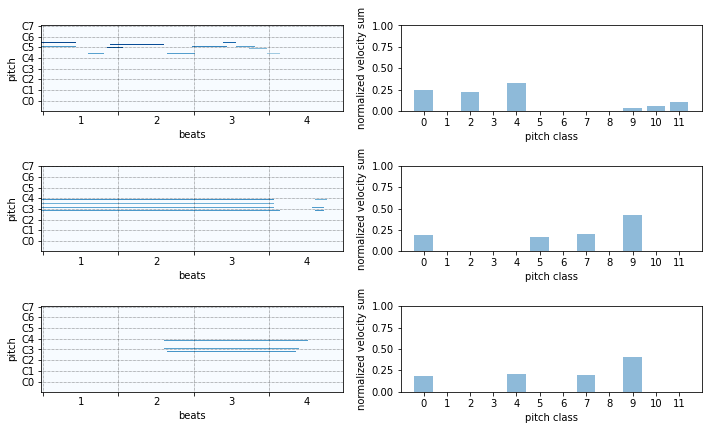

In [2]:
reload(custom_loss)
batch = train_units[1:4]

# Plot pitch histograms
batch_of_histograms = K.eval(custom_loss.get_pitch_class_histogram(batch))

fig, ax = plt.subplots(len(batch_of_histograms),2)
fig.set_size_inches(10, len(batch_of_histograms)*2, forward=True)
for index, hist in enumerate(batch_of_histograms):
    # Pianoroll plot
    pianoroll_utils.plot_pianoroll(ax[index,0], batch[index].squeeze(), min_pitch=MIN_PITCH, max_pitch=MAX_PITCH, beat_resolution=24, cmap='Blues')
    # Histogram plot
    pianoroll_utils.plot_pitch_class_histogram(ax[index,1], hist)

fig.tight_layout()
plt.savefig('fig/pitch_histograms.eps', format='eps', dpi=1000)

##### Comparing histogram distance metrics

[0.7864077]
[0.07988166]
[0.7864077]
[0.07988166]


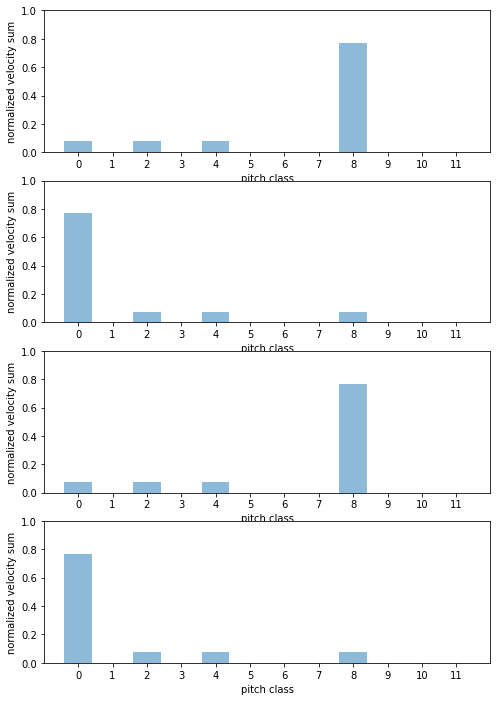

In [6]:
batch = np.zeros((4, 96, 96, 1))
batch[0, 60] = 0.1
batch[0, 62] = 0.1
batch[0, 64] = 0.1
batch[0, 68] = 1
batch[1, 72] = 1
batch[1, 62] = 0.1
batch[1, 64] = 0.1
batch[1, 68] = 0.1

batch[2, 60] = 0.1
batch[2, 62] = 0.1
batch[2, 64] = 0.1
batch[2, 68] = 1
batch[3, 72] = 1
batch[3, 62] = 0.1
batch[3, 64] = 0.1
batch[3, 68] = 0.1

# Get pitch distance
batch1 = batch[0][np.newaxis, ...]
batch2 = batch[1][np.newaxis, ...]
print(K.eval(custom_loss.pitch_histogram_distance(batch1, batch2, 'cosine')))
print(K.eval(custom_loss.pitch_histogram_distance(batch1, batch2, 'mse')))

# Get pitch distance
batch1 = batch[2][np.newaxis, ...]
batch2 = batch[3][np.newaxis, ...]
print(K.eval(custom_loss.pitch_histogram_distance(batch1, batch2, 'cosine')))
print(K.eval(custom_loss.pitch_histogram_distance(batch1, batch2, 'mse')))

# Plot pitch histograms
batch_of_histograms = K.eval(custom_loss.get_pitch_class_histogram(batch))

fig, ax = plt.subplots(len(batch_of_histograms), 1)
fig.set_size_inches(8, len(batch_of_histograms)*3, forward=True)
for index, hist in enumerate(batch_of_histograms):
    x_pos = np.arange(len(hist))
    ax[index].bar(x_pos, hist, align='center', alpha=0.5)
    ax[index].set_xticks(x_pos, minor=False)
    ax[index].set_ylabel('normalized velocity sum')
    ax[index].set_xlabel('pitch class')
    ax[index].set_ylim([0,1])

plt.savefig('fig/pitch_histograms_distance.eps', format='eps', dpi=1000)

#### Custom loss function for Keras

On creating custom loss functions for Keras: [StackOverflow answer](https://stackoverflow.com/questions/46663013/what-is-y-true-and-y-pred-when-creating-a-custom-metric-in-keras?noredirect=1&lq=1)

##### y_true and y_pred
The tensor y_true is the true data (or target) you pass to the fit method.
It's a conversion of the numpy array y_train into a tensor.

The tensor y_pred is the data predicted (calculated) by your model.

Both y_true and y_pred have exactly the same shape, always.

##### The shape of y_true

It contains an entire batch. Its first dimension is always the batch size, and it must exist, even if the batch has only one element.

Two very easy ways to find the shape of y_true are:
- check your true/target data: print(Y_train.shape)
- check your model.summary() and see the last output

But its first dimension will be the batch size. 

So, if your last layer outputs (None, 1), the shape of y_true is (batch, 1). If the last layer outputs (None, 200,200, 3), then y_true will be (batch, 200,200,3).

**In our case, for the convolutional models we expect a shape of `(None, 96, 96, 1)`.**

In [20]:
def loss_keras(y_true, y_pred):
    # Convert (None, 96, 96, 1) to (None, 96, 96)
    y_true = K.squeeze(y_true, axis=-1)
    y_pred = K.squeeze(y_pred, axis=-1)
    
    rhythm_loss = custom_loss.score_note_onsets_keras(y_pred)
    pitch_loss = custom_loss.pitch_intersection_over_union_keras(y_true, y_pred)
    return rhythm_loss + pitch_loss

def loss_np(y_true, y_pred):
    rhythm_loss = pianoroll_utils.score_note_onsets(y_pred, MIN_PITCH, MAX_PITCH)
    pitch_loss = pianoroll_utils.pitch_intersection_over_union(y_true, y_pred, MIN_PITCH, MAX_PITCH)
    return rhythm_loss + pitch_loss

def check_loss():
    # Pianoroll A
    a = np.zeros((96,96))
    a[60,:24] = 1
    a[62,24:48] = 1
    a[64,48:72] = 1
    a[65,72:] = 1

    # Pianoroll B
    b = a.copy()
    b[62,:] = 0
    b[62,36:48] = 1 # Swing the note by half a beat

    y_a = np.random.random((BATCH_SIZE, NUM_PITCHES, NUM_TICKS))
    y_b = np.random.random((BATCH_SIZE, NUM_PITCHES, NUM_TICKS))

    out1 = K.eval(loss_keras(y_a, y_b))
    out2 = loss_np(y_a, y_b)

    print np.linalg.norm(out1), np.linalg.norm(out2)
    print np.linalg.norm(out1-out2)
    assert out1.shape == out2.shape
    assert np.linalg.norm(out1-out2) < EPSILON

(10, 96, 96, 1)
0.00047149128
-1.0
0.7309524


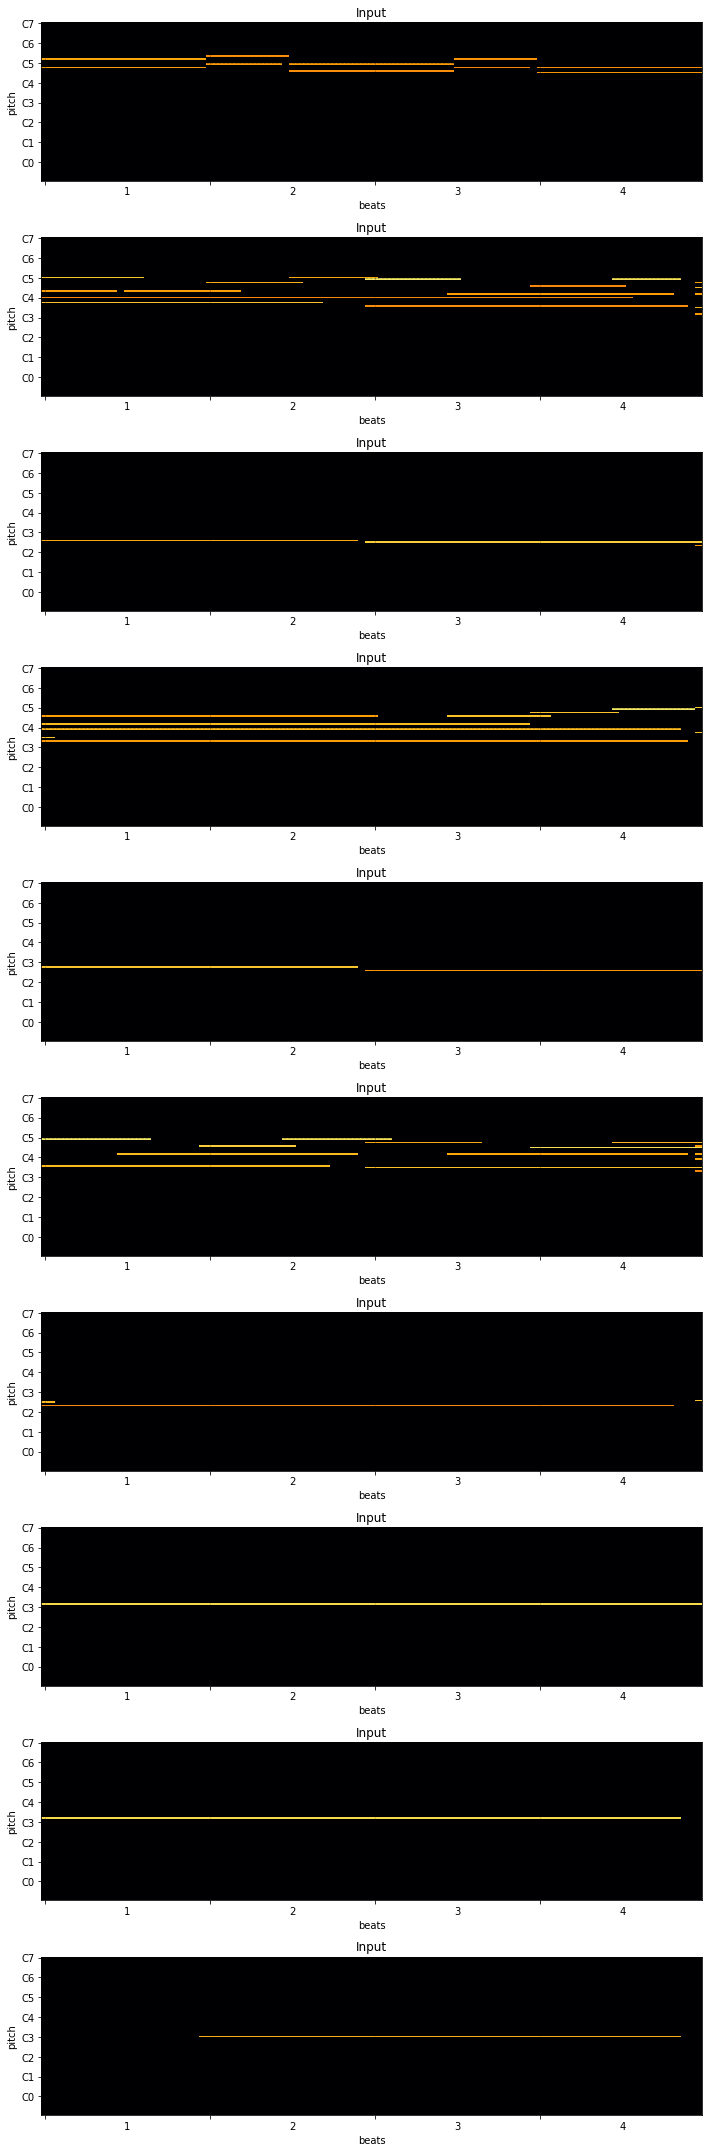

In [7]:
reload(custom_loss)

# Grab some sample units
BATCH_SIZE = 10
batch = input_train[:BATCH_SIZE]
batch2 = input_train[BATCH_SIZE:2*BATCH_SIZE]
print(batch.shape)

# Visualize the units
fig, ax = plt.subplots(BATCH_SIZE, 1)
fig.set_size_inches(10, BATCH_SIZE*3, forward=True)
for index in range(BATCH_SIZE):
    # Plot comparison
    ax[index].set_title('Input')
    pianoroll_utils.plot_pianoroll(ax[index], batch[index].squeeze(), min_pitch=MIN_PITCH, max_pitch=MAX_PITCH, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Batch loss
print(K.eval(custom_loss.smoothness_loss(batch)))
print(K.eval(custom_loss.onsets_loss(batch)))
print(K.eval(custom_loss.pitch_loss(batch, batch2)))

# check_loss(batch)

#### Reformulating loss functions with gradient 

Loss functions need to be differentiable. Not all of Keras' backend functions are differentiable. Here's what we know:

Differentiable ops:
- Indexing
- +, -, *, /
- K.squeeze
- K.spatial_2d_padding

Non-differentiable ops:
- K.argmax
- K.round
- K.eval
- K.greater
- K.cast bool to float, int to float

Turns out, it's not just the op itself which determines differentiability. It's about how you chain the ops. For example, `K.mean(y_true)` has no gradient and will error. On the other hand, `K.mean(y_true - y_pred)` does have a gradient and can train without issue.

In [22]:
reload(custom_loss)

# Loss function
def test_loss(input_x, output_x):
    return custom_loss.onset_distance(input_x, output_x)

# Dummy model
input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))
x = Flatten()(input_mat)
x = Dense(2, activation='relu')(x)
x = Dense(NUM_PITCHES*NUM_TICKS, activation='sigmoid')(x)
output_mat = Reshape((NUM_PITCHES, NUM_TICKS, 1))(x)
model = Model(input_mat, output_mat)
model.compile(optimizer='adam', loss=test_loss)
model.summary()

# Train the model
model.fit(train_units, train_units,
          epochs=1,
          shuffle='batch',
          validation_data=(test_units, test_units))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18434     
_________________________________________________________________
dense_4 (Dense)              (None, 9216)              27648     
_________________________________________________________________
reshape_2 (Reshape)          (None, 96, 96, 1)         0         
Total params: 46,082
Trainable params: 46,082
Non-trainable params: 0
_________________________________________________________________
Train on 4094 samples, validate on 122 samples
Epoch 1/1
4094/4094 [==============================] - 9s 2ms/step - loss: 10.8517 - val_lo

## Investigating recorded input/output from live demo

##### 16th May 2018
- After plotting the graphs, it's quite clear that actually the structure of the music _looks_ the same. Overall rhythmic structure is definitely there, and the general octave level is also respected.
- But why does it still sound so bad? Look at IOU: Turns out that all the input-comp pairs have less than 33% IOU, which implies that the **key of the music is being ignored**! How to fix this?
    - ~~Check: What is the IOU of the decoded input like? (Hopefully much, much better)~~
        - Apparently, not any better? The IOU between decoded and unit selection are much between than the either IOU to the input. Which means that **the key/pitch information is being lost within the encoding part of the process itself**, so increasing the library for unit selection would not lead to any improvement here.
    - It is likely that more units in all transpositions will help, but this is not the root problem.
    - The main problem this implies that the latent space has pianorolls in clusters of general appearance rather than by key. **How can we make sure that units of different keys are strongly clustered apart**?

#### Call and response

In [11]:
latent_dim = 50
epsilon_std = 1.0

MODEL_FILE = './models/vae_v9_encoder_latent50.h5'
encoder = load_model(MODEL_FILE, custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v9_decoder_latent50.h5'
decoder = load_model(MODEL_FILE, custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

In [8]:
!ls pickle_jar/demo_recordings/call_and_response/

generated_pianoroll_0.npy   recorded_pianoroll_0.npy
generated_pianoroll_10.npy  recorded_pianoroll_10.npy
generated_pianoroll_11.npy  recorded_pianoroll_11.npy
generated_pianoroll_12.npy  recorded_pianoroll_12.npy
generated_pianoroll_13.npy  recorded_pianoroll_13.npy
generated_pianoroll_14.npy  recorded_pianoroll_14.npy
generated_pianoroll_15.npy  recorded_pianoroll_15.npy
generated_pianoroll_16.npy  recorded_pianoroll_16.npy
generated_pianoroll_17.npy  recorded_pianoroll_17.npy
generated_pianoroll_18.npy  recorded_pianoroll_18.npy
generated_pianoroll_19.npy  recorded_pianoroll_19.npy
generated_pianoroll_1.npy   recorded_pianoroll_1.npy
generated_pianoroll_20.npy  recorded_pianoroll_20.npy
generated_pianoroll_21.npy  recorded_pianoroll_21.npy
generated_pianoroll_22.npy  recorded_pianoroll_22.npy
generated_pianoroll_23.npy  recorded_pianoroll_23.npy
generated_pianoroll_24.npy  recorded_pianoroll_24.npy
generated_pianoroll_25.npy  recorded_pianoroll_25.npy
generated_pianoroll_26.npy  re

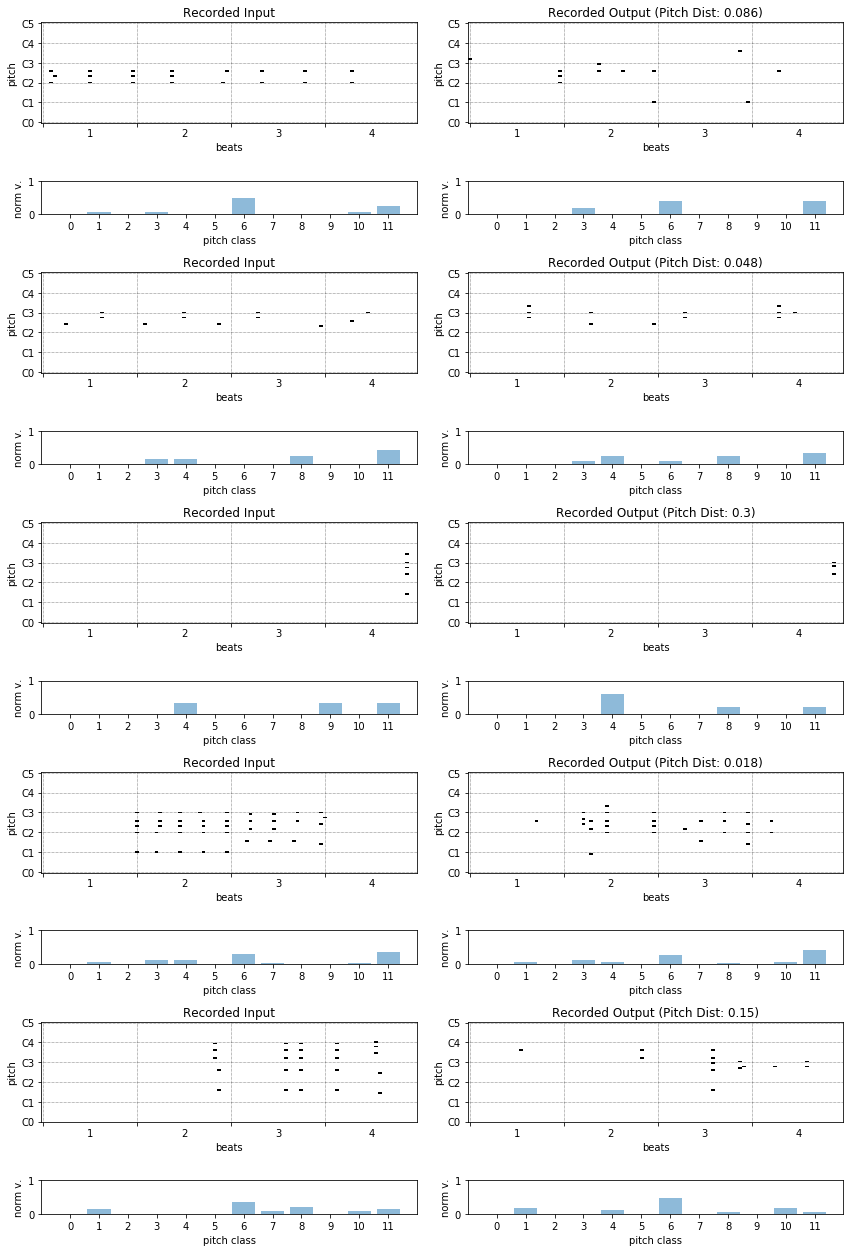

In [52]:
reload(pianoroll_utils)
NUM_RECORDINGS = 50
NUM_SAMPLES = 5
indices = [31, 48, 16, 42, 38]# + list(np.random.choice(np.arange(NUM_RECORDINGS), NUM_SAMPLES, replace=False))

fig, ax = plt.subplots(2*len(indices), 2, gridspec_kw = {'height_ratios':len(indices)*[3,1]})
fig.set_size_inches(12, len(indices)*3.5, forward=True)
for index, recording_index in enumerate(indices):

    input_pianoroll = np.load('pickle_jar/demo_recordings/call_and_response/recorded_pianoroll_{}.npy'.format(recording_index))
    # Get binarized onsets
    input_pianoroll = np.pad(input_pianoroll, ((0,0),(1,0)), 'constant')
    input_pianoroll = input_pianoroll[:,1:] - input_pianoroll[:,:-1]
    input_pianoroll = (input_pianoroll > 0.1).astype('float16')
    
    comp_pianoroll = np.load('pickle_jar/demo_recordings/call_and_response/generated_pianoroll_{}.npy'.format(recording_index))
    # Deep learning representation - include batch and channel dimension
    input_pianoroll_dl = pianoroll_utils.crop_pianoroll(input_pianoroll, MIN_PITCH, MAX_PITCH)[np.newaxis, ..., np.newaxis]
    comp_pianoroll_dl = pianoroll_utils.crop_pianoroll(comp_pianoroll, MIN_PITCH, MAX_PITCH)[np.newaxis, ..., np.newaxis]
    # Run through autoencoder
#     decoded_pianoroll_dl = decoder.predict(encoder.predict(input_pianoroll_dl))
#     decoded_pianoroll = pianoroll_utils.pianoroll_preprocess(
#         pianoroll_utils.pad_pianoroll(decoded_pianoroll_dl.squeeze(), MIN_PITCH, MAX_PITCH)
#     )
#     decoded_pianoroll = pianoroll_utils.pad_pianoroll(decoded_pianoroll_dl.squeeze(), MIN_PITCH, MAX_PITCH)
    
    pitch_dist_recorded = K.eval(custom_loss.pitch_histogram_distance(input_pianoroll_dl, comp_pianoroll_dl))[0]
#     pitch_dist_decoded = K.eval(custom_loss.pitch_histogram_distance(input_pianoroll_dl, decoded_pianoroll_dl))[0]
    input_hist = K.eval(custom_loss.get_pitch_class_histogram(input_pianoroll_dl))[0]
    comp_hist = K.eval(custom_loss.get_pitch_class_histogram(comp_pianoroll_dl))[0]
#     decoded_hist = K.eval(custom_loss.get_pitch_class_histogram(decoded_pianoroll_dl))[0]

    # Zoom
    min_pitch = 24
    max_pitch = 84
    input_pianoroll_zoom = pianoroll_utils.crop_pianoroll(input_pianoroll, min_pitch, max_pitch)
    comp_pianoroll_zoom = pianoroll_utils.crop_pianoroll(comp_pianoroll, min_pitch, max_pitch)
    
    # Plot comparison
    ax[index*2, 0].set_title('Recorded Input')
    ax[index*2, 1].set_title('Recorded Output (Pitch Dist: {0:.2})'.format(pitch_dist_recorded))
#     ax[0, 2].set_title('Decoded (Pitch Dist: {0:.2})'.format(pitch_dist_decoded))
    pianoroll_utils.plot_pianoroll(ax[index*2, 0], input_pianoroll_zoom, min_pitch, max_pitch, cmap='bone_r')
    pianoroll_utils.plot_pianoroll(ax[index*2, 1], comp_pianoroll_zoom, min_pitch, max_pitch, cmap='bone_r')
#     pianoroll_utils.plot_pianoroll(ax[0, 2], decoded_pianoroll, beat_resolution=24)
    pianoroll_utils.plot_pitch_class_histogram(ax[index*2+1, 0], comp_hist)
    pianoroll_utils.plot_pitch_class_histogram(ax[index*2+1, 1], input_hist)
#     pianoroll_utils.plot_pitch_class_histogram(ax[1, 2], decoded_hist)

fig.tight_layout()
plt.savefig('fig/demotest_callandresponse.eps', format='eps', dpi=1000)

    # Play comparison
#     pianoroll_utils.play_pianoroll(input_pianoroll, filelabel="{}_input".format(index), is_onsets_matrix=True, program_number=13)
#     pianoroll_utils.play_pianoroll(comp_pianoroll, filelabel="{}_comp".format(index), is_onsets_matrix=True, program_number=13)
#     pianoroll_utils.play_pianoroll(decoded_pianoroll, filelabel="{}_comp".format(index), is_onsets_matrix=True, program_number=13)

#### Bassline Accompaniment

In [53]:
!ls pickle_jar/demo_recordings/accompaniment/

mono_generated_pianoroll_0.npy	 mono_recorded_pianoroll_0.npy
mono_generated_pianoroll_10.npy  mono_recorded_pianoroll_10.npy
mono_generated_pianoroll_11.npy  mono_recorded_pianoroll_11.npy
mono_generated_pianoroll_12.npy  mono_recorded_pianoroll_12.npy
mono_generated_pianoroll_13.npy  mono_recorded_pianoroll_13.npy
mono_generated_pianoroll_14.npy  mono_recorded_pianoroll_14.npy
mono_generated_pianoroll_15.npy  mono_recorded_pianoroll_15.npy
mono_generated_pianoroll_16.npy  mono_recorded_pianoroll_16.npy
mono_generated_pianoroll_17.npy  mono_recorded_pianoroll_17.npy
mono_generated_pianoroll_18.npy  mono_recorded_pianoroll_18.npy
mono_generated_pianoroll_19.npy  mono_recorded_pianoroll_19.npy
mono_generated_pianoroll_1.npy	 mono_recorded_pianoroll_1.npy
mono_generated_pianoroll_20.npy  mono_recorded_pianoroll_20.npy
mono_generated_pianoroll_21.npy  mono_recorded_pianoroll_21.npy
mono_generated_pianoroll_22.npy  mono_recorded_pianoroll_22.npy
mono_generated_pianoroll_23.npy  mono_record

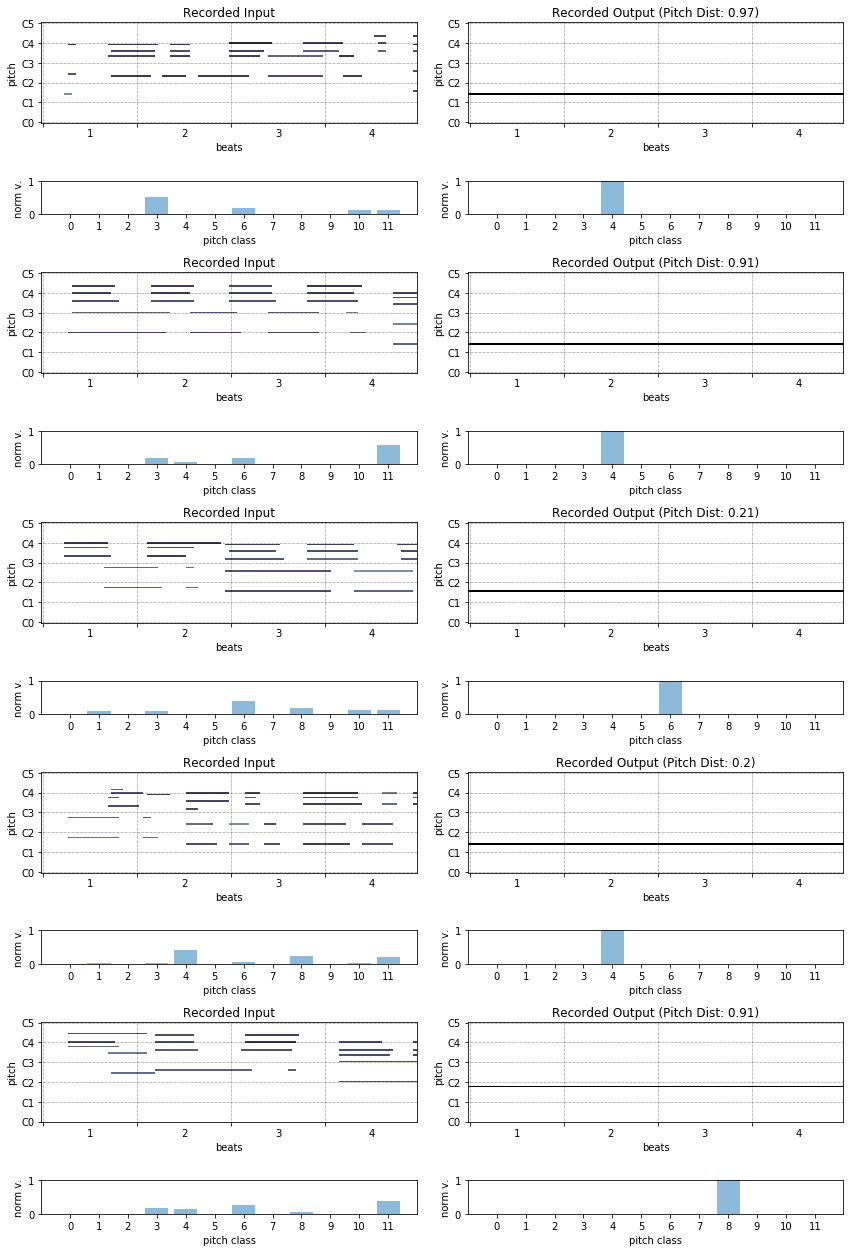

In [60]:
reload(pianoroll_utils)
NUM_RECORDINGS = 50
NUM_SAMPLES = 5
indices = [30, 16, 8, 29, 6] #list(np.random.choice(np.arange(NUM_RECORDINGS), NUM_SAMPLES, replace=False))

fig, ax = plt.subplots(2*len(indices), 2, gridspec_kw = {'height_ratios':len(indices)*[3,1]})
fig.set_size_inches(12, len(indices)*3.5, forward=True)
for index, recording_index in enumerate(indices):
    input_pianoroll = np.load('pickle_jar/demo_recordings/accompaniment/mono_recorded_pianoroll_{}.npy'.format(recording_index))
    comp_pianoroll = np.load('pickle_jar/demo_recordings/accompaniment/mono_generated_pianoroll_{}.npy'.format(recording_index))
    # Deep learning representation - include batch and channel dimension
    input_pianoroll_dl = pianoroll_utils.crop_pianoroll(input_pianoroll, MIN_PITCH, MAX_PITCH)[np.newaxis, ..., np.newaxis]
    comp_pianoroll_dl = pianoroll_utils.crop_pianoroll(comp_pianoroll, MIN_PITCH, MAX_PITCH)[np.newaxis, ..., np.newaxis]
    # Run through autoencoder
#     decoded_pianoroll_dl = decoder.predict(encoder.predict(input_pianoroll_dl))
#     decoded_pianoroll = pianoroll_utils.pianoroll_preprocess(
#         pianoroll_utils.pad_pianoroll(decoded_pianoroll_dl.squeeze(), MIN_PITCH, MAX_PITCH)
#     )
#     decoded_pianoroll = pianoroll_utils.pad_pianoroll(decoded_pianoroll_dl.squeeze(), MIN_PITCH, MAX_PITCH)
    
    pitch_dist_recorded = K.eval(custom_loss.pitch_histogram_distance(input_pianoroll_dl, comp_pianoroll_dl))[0]
#     pitch_dist_decoded = K.eval(custom_loss.pitch_histogram_distance(input_pianoroll_dl, decoded_pianoroll_dl))[0]
    input_hist = K.eval(custom_loss.get_pitch_class_histogram(input_pianoroll_dl))[0]
    comp_hist = K.eval(custom_loss.get_pitch_class_histogram(comp_pianoroll_dl))[0]
#     decoded_hist = K.eval(custom_loss.get_pitch_class_histogram(decoded_pianoroll_dl))[0]

    # Zoom
    min_pitch = 24
    max_pitch = 84
    input_pianoroll_zoom = pianoroll_utils.crop_pianoroll(input_pianoroll, min_pitch, max_pitch)
    comp_pianoroll_zoom = pianoroll_utils.crop_pianoroll(comp_pianoroll, min_pitch, max_pitch)
    
    # Plot comparison
    ax[index*2, 0].set_title('Recorded Input')
    ax[index*2, 1].set_title('Recorded Output (Pitch Dist: {0:.2})'.format(pitch_dist_recorded))
#     ax[0, 2].set_title('Decoded (Pitch Dist: {0:.2})'.format(pitch_dist_decoded))
    pianoroll_utils.plot_pianoroll(ax[index*2, 0], input_pianoroll_zoom, min_pitch, max_pitch, cmap='bone_r')
    pianoroll_utils.plot_pianoroll(ax[index*2, 1], comp_pianoroll_zoom, min_pitch, max_pitch, cmap='bone_r')
#     pianoroll_utils.plot_pianoroll(ax[0, 2], decoded_pianoroll, beat_resolution=24)
    pianoroll_utils.plot_pitch_class_histogram(ax[index*2+1, 0], input_hist)
    pianoroll_utils.plot_pitch_class_histogram(ax[index*2+1, 1], comp_hist)
#     pianoroll_utils.plot_pitch_class_histogram(ax[1, 2], decoded_hist)

fig.tight_layout()
plt.savefig('fig/demotest_accompaniment.eps', format='eps', dpi=1000)

    # Play comparison
#     pianoroll_utils.play_pianoroll(input_pianoroll, filelabel="{}_input".format(index), is_onsets_matrix=True, program_number=13)
#     pianoroll_utils.play_pianoroll(comp_pianoroll, filelabel="{}_comp".format(index), is_onsets_matrix=True, program_number=13)
#     pianoroll_utils.play_pianoroll(decoded_pianoroll, filelabel="{}_comp".format(index), is_onsets_matrix=True, program_number=13)

## Investigating playpianoroll_events

In [3]:
from keras.models import load_model
MODEL_AUTOENCODER_FILE = './models/autoencoder_v4.h5'
autoencoder = load_model(MODEL_AUTOENCODER_FILE)

Using TensorFlow backend.


In [4]:
from keras.models import Model
# Normalize input_pianoroll
input_pianoroll = np.load('recorded_pianoroll.npy')
input_pianoroll = input_pianoroll / 127.
# Get encoding of the input
input_pianoroll = input_pianoroll.reshape(1, 128, 96, 1)
autoencoder_output = autoencoder.predict(input_pianoroll) # (1, 128, 96, 1)
assert autoencoder_output.shape == (1, 128, 96, 1)
print "Getting autoencoder stuff", autoencoder_output.shape
# print np.sum(input_pianoroll - autoencoder_output)
print np.sum(input_pianoroll)
print np.amin(autoencoder_output)
# output_pianoroll = autoencoder_output[0].reshape(128, 96)

Getting autoencoder stuff (1, 128, 96, 1)
55.90551181102363
0.0


[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  3.4705973  20.77994    24.45203     0.877367    0.          3.9844081
  6.5914383   5.171249    1.4545087   2.5562441   3.8582234   0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.03607762  9.261589   13.108125   16.930813   20.213509   17.428322
 17.123474    3.6582694   3.8401468   0.          0.          0.90885544
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.

0

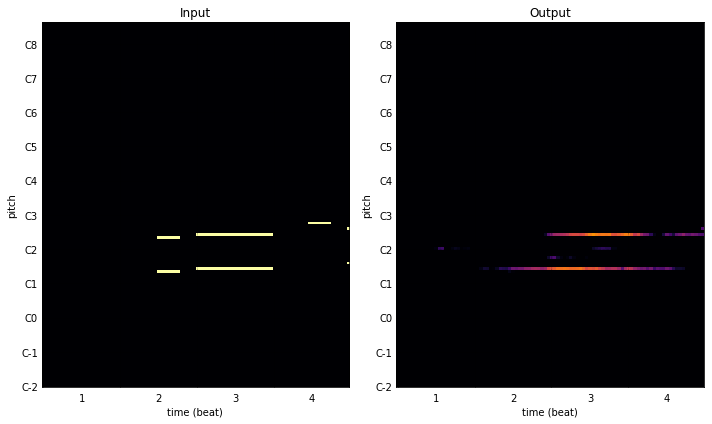

In [46]:
import pianoroll_utils

sample_input = input_pianoroll.reshape(128,96).swapaxes(0,1).reshape(96, 128) * 127
sample_output = autoencoder_output[0].swapaxes(0,1).reshape(96, 128) * 127
print sample_output[:,48]
# Plot comparison
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[1], sample_output, beat_resolution=24, cmap='inferno')
fig.tight_layout()

pianoroll_utils.playPianoroll(sample_input)
pianoroll_utils.playPianoroll(sample_output)

In [49]:
input_pianoroll = np.load('recorded_pianoroll.npy')
print input_pianoroll.shape

print("")
print("Input")
play_midi_events(pianoroll_2_events(input_pianoroll))

print("")
print("Output")
play_midi_events(pianoroll_2_events(autoencoder_output.reshape(128,96) * 127))

(128, 96)

Input

Output


In [48]:
# print np.amax(autoencoder_output)
output = autoencoder_output.reshape(128,96) / np.amax(autoencoder_output) * 127
print output[48,:]

0.76522815
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  4.5353756  27.15522    31.953907    1.146543    0.          5.206824
  8.61369     6.757787    1.9007516   3.3404996   5.041926    0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.04714623 12.103043   17.129694   22.125185   26.415009   22.775328
 22.376951    4.7806253   5.0183034   0.          0.          1.1876922
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        

note_on channel=0 note=48 velocity=117 time=0.25
note_on channel=0 note=48 velocity=0 time=0.0840909090909
note_on channel=0 note=48 velocity=127 time=0.0204545454545
note_on channel=0 note=48 velocity=0 time=0.125
note_on channel=0 note=41 velocity=126 time=0.0613636363636
note_on channel=0 note=40 velocity=127 time=0.188636363636
note_on channel=0 note=40 velocity=0 time=0.0409090909091
note_on channel=0 note=53 velocity=127 time=0.188636363636
note_on channel=0 note=45 velocity=127 time=0.0204545454545
note_on channel=0 note=45 velocity=0 time=0.104545454545
note_on channel=0 note=45 velocity=127 time=0.0204545454545
note_on channel=0 note=45 velocity=0 time=0.0613636363636
note_on channel=0 note=45 velocity=80 time=0.0431818181818
note_on channel=0 note=45 velocity=0 time=0.0409090909091
note_on channel=0 note=48 velocity=113 time=0
note_on channel=0 note=48 velocity=0 time=0.188636363636
note_on channel=0 note=48 velocity=90 time=0.0409090909091
note_on channel=0 note=48 velocity=0 time=0.0204545454545
note_on channel=0 note=53 velocity=0 time=0.188636363636
note_on channel=0 note=53 velocity=127 time=0.0409090909091
note_on channel=0 note=41 velocity=0 time=0.145454545455
note_on channel=0 note=55 velocity=127 time=0.104545454545
note_on channel=0 note=53 velocity=0 time=0.0204545454545
note_on channel=0 note=55 velocity=0 time=0

note_on channel=5 note=48 velocity=15 time=0
note_on channel=5 note=48 velocity=0 time=0
note_on channel=5 note=48 velocity=3 time=0
note_on channel=5 note=48 velocity=0 time=0
note_on channel=5 note=41 velocity=8 time=0
note_on channel=5 note=41 velocity=0 time=0
note_on channel=5 note=41 velocity=50 time=0
note_on channel=5 note=40 velocity=3 time=0
note_on channel=5 note=40 velocity=0 time=0
note_on channel=5 note=53 velocity=66 time=0
note_on channel=5 note=45 velocity=14 time=0
note_on channel=5 note=45 velocity=0 time=0
note_on channel=5 note=45 velocity=4 time=0
note_on channel=5 note=45 velocity=0 time=0
note_on channel=5 note=45 velocity=2 time=0
note_on channel=5 note=45 velocity=0 time=0
note_on channel=5 note=48 velocity=12 time=0
note_on channel=5 note=48 velocity=0 time=0
note_on channel=5 note=53 velocity=0 time=0
note_on channel=5 note=53 velocity=32 time=0
note_on channel=5 note=41 velocity=0 time=0
note_on channel=5 note=55 velocity=29 time=0

## LSTM sequence learning

Sources:
- Keras [docs](https://keras.io/preprocessing/sequence/#timeseriesgenerator) for TimeSeriesGenerator
- [StackOverflow](https://stackoverflow.com/questions/49555701/timeseriesgenerator-for-two-or-more-inputs) question on multiple input timeseriesgenerator

In [1]:
import keras
from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Model, Sequential  
from keras.layers import Input, Activation, Dense, LSTM, Concatenate
# from keras.layers.core import Dense, Activation
# from keras.layers.recurrent import LSTM

import pandas as pd
import numpy as np

/home/human/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Sequence predictor

In [8]:
from keras.utils import Sequence

class TimeseriesGeneratorCustom(Sequence):
    """Utility class for generating batches of temporal data.
    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.
    # Arguments
    """

    def __init__(self, data, targets, length,
                 sampling_rate=1,
                 stride=1,
                 start_index=0,
                 end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=128):
        self.data = data
        self.targets = targets
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length
        if end_index is None:
            end_index = len(data) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size

        if self.start_index > self.end_index:
            raise ValueError('`start_index+length=%i > end_index=%i` '
                             'is disallowed, as no part of the sequence '
                             'would be left to be used as current step.'
                             % (self.start_index, self.end_index))

    def __len__(self):
        return int(np.ceil(
            (self.end_index - self.start_index + 1) /
            (self.batch_size * self.stride)))

    def _empty_batch(self, num_rows):
        samples_shape = [num_rows, self.length // self.sampling_rate]
        samples_shape.extend(self.data.shape[1:])
        targets_shape = [num_rows]
        targets_shape.extend(self.targets.shape[1:])
        return np.empty(samples_shape), np.empty(targets_shape)

    def __getitem__(self, index):
        if self.shuffle:
            rows = np.random.randint(
                self.start_index, self.end_index + 1, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size *
                                    self.stride, self.end_index + 1), self.stride)

        samples, targets = self._empty_batch(len(rows))
        for j, row in enumerate(rows):
            indices = range(rows[j] - self.length, rows[j], self.sampling_rate)
            samples[j] = self.data[indices]
            targets[j] = self.targets[rows[j]]
        if self.reverse:
            return samples[:, ::-1, ...], targets
        return samples, targets

    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        pass

    def __iter__(self):
        """Create an infinite generator that iterate over the Sequence."""
        while True:
            for item in (self[i] for i in range(len(self))):
                yield item

In [9]:
# Use keras TimeseriesGenerator to turn a sequence
# into multiple windows of sequences
WINDOW_LENGTH = 4

# def get_generator(data, targets, window_length = 5, batch_size = 32):
#     while True:
#         data_gen = TimeseriesGenerator(data, targets, length=window_length, 
#                                        sampling_rate=1, batch_size=batch_size)
#         for i in range(len(data_gen)):
#             x, y = data_gen[i]
#             yield x, y

class CustomGen(TimeseriesGenerator):
    def __getitem__(self, idx):
        x, y = TimeseriesGenerator.__getitem__(self, idx)
        # do processing here
        return x, y

data = np.arange(0,100).reshape(-1,1)
data_gen_custom = TimeseriesGeneratorCustom(data, data, length=WINDOW_LENGTH, sampling_rate=1, batch_size=1)
data_gen = TimeseriesGenerator(data, data, length=WINDOW_LENGTH, sampling_rate=1, batch_size=1)

In [10]:
data_dim = 1
input1 = Input(shape=(WINDOW_LENGTH, data_dim))
lstm1 = LSTM(100)(input1)

hidden = Dense(20, activation='relu')(lstm1)
output = Dense(data_dim, activation='linear')(hidden)

model = Model(inputs=input1, outputs=output)
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________


In [11]:
# and now train the model
# batch_size should be appropriate to your memory size
model.fit_generator(generator=data_gen_custom,
                    steps_per_epoch=32,
                    epochs=50)

Epoch 1/50
32/32 [==============================] - 1s 31ms/step - loss: 2470.8388 - acc: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 2437.9167 - acc: 0.0312
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 1884.0048 - acc: 0.0625
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 861.9349 - acc: 0.0312
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 885.3431 - acc: 0.0312
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 548.7989 - acc: 0.0625
Epoch 7/50
32/32 [==============================] - 0s 7ms/step - loss: 324.5852 - acc: 0.0938
Epoch 8/50
32/32 [==============================] - 0s 6ms/step - loss: 129.7269 - acc: 0.1250
Epoch 9/50
32/32 [==============================] - 0s 6ms/step - loss: 88.3675 - acc: 0.1250
Epoch 10/50
32/32 [==============================] - 0s 7ms/step - loss: 38.0719 - acc: 0.2188
Epoch 11/50
32/32 [========================

In [163]:
input1 = np.arange(80,84).reshape(1,WINDOW_LENGTH,1)

predicted = model.predict(input1)
print(predicted)

[[88.76638]]


#### Multi-sequence predictor

In [17]:
from keras.utils import Sequence

class TimeseriesGeneratorTwoInputs(Sequence):
    """Utility class for generating batches of temporal data.
    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.
    
    Adapted from the TimeseriesGenerator class:
    https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
    """

    def __init__(self, data1, data2, targets, length,
                 sampling_rate=1,
                 stride=1,
                 start_index=0,
                 end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=128):
        self.data1 = data1
        self.data2 = data2
        assert len(data1) == len(data2)
        self.targets = targets
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length
        if end_index is None:
            end_index = len(data1) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size

        if self.start_index > self.end_index:
            raise ValueError('`start_index+length=%i > end_index=%i` '
                             'is disallowed, as no part of the sequence '
                             'would be left to be used as current step.'
                             % (self.start_index, self.end_index))

    def __len__(self):
        return int(np.ceil(
            (self.end_index - self.start_index + 1) /
            (self.batch_size * self.stride)))

    def _empty_batch(self, num_rows):
        samples_shape = [num_rows, self.length // self.sampling_rate]
        samples_shape.extend(self.data1.shape[1:])
        targets_shape = [num_rows]
        targets_shape.extend(self.targets.shape[1:])
        return np.empty(samples_shape), np.empty(samples_shape), np.empty(targets_shape)

    def __getitem__(self, index):
        if self.shuffle:
            rows = np.random.randint(
                self.start_index, self.end_index + 1, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size *
                                    self.stride, self.end_index + 1), self.stride)

        samples1, samples2, targets = self._empty_batch(len(rows))
        for j, row in enumerate(rows):
            indices = range(rows[j] - self.length, rows[j], self.sampling_rate)
            samples1[j] = self.data1[indices]
            samples2[j] = self.data2[indices]
            targets[j] = self.targets[rows[j]]
        if self.reverse:
            return [samples1[:, ::-1, ...], samples2[:, ::-1, ...]], targets
        return [samples1, samples2], targets


In [18]:
data1 = np.arange(0,100).reshape(-1,1)
data2 = np.arange(0,100).reshape(-1,1)
data_gen = TimeseriesGeneratorTwoInputs(data1, data2, data2, length=WINDOW_LENGTH, sampling_rate=1, batch_size=1)

In [25]:
data_dim = 1

# First layer
input1 = Input(shape=(WINDOW_LENGTH, data_dim))
input2 = Input(shape=(WINDOW_LENGTH, data_dim))
lstm1 = LSTM(100)(input1)
lstm2 = LSTM(100)(input2)

# Second layer
merged = keras.layers.concatenate([lstm1, lstm2])

# Third layer
hidden = Dense(20, activation='relu')(merged)
output = Dense(data_dim, activation='linear')(hidden)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 4, 1)         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 4, 1)         0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 100)          40800       input_9[0][0]                    
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 100)          40800       input_10[0][0]                   
__________________________________________________________________________________________________
concatenat

In [26]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
# model.fit(X_train, y_train, batch_size=450, epochs=10, validation_split=0.05)
model.fit_generator(generator=data_gen,
                    steps_per_epoch=32,
                    epochs=50)

Epoch 1/50
32/32 [==============================] - 2s 63ms/step - loss: 2304.6477 - acc: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 1496.8769 - acc: 0.0000e+00
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 773.9431 - acc: 0.0312
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 312.1340 - acc: 0.0938
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 136.2790 - acc: 0.0625
Epoch 6/50
32/32 [==============================] - 0s 8ms/step - loss: 55.5633 - acc: 0.2188
Epoch 7/50
32/32 [==============================] - 0s 9ms/step - loss: 25.0596 - acc: 0.0938
Epoch 8/50
32/32 [==============================] - 0s 8ms/step - loss: 11.9308 - acc: 0.0938
Epoch 9/50
32/32 [==============================] - 0s 9ms/step - loss: 9.8678 - acc: 0.1562  ETA: 0s - loss: 10.1129 - acc: 0.000
Epoch 10/50
32/32 [==============================] - 0s 8ms/step - loss: 4.8735 - acc: 0.1875
Epoch 1

In [29]:
input1 = np.arange(80,84).reshape(1,4,1)
input2 = np.arange(80,84).reshape(1,4,1) #np.arange(80,85).reshape(1,5,1)

predicted = model.predict([input1,input2])
print(predicted)

[[83.56241]]


#### Stateful predictor

Inspired by this [question](https://stackoverflow.com/questions/38081263/stream-output-of-predictions-in-keras).

In [153]:
# Use keras TimeseriesGenerator to turn a sequence
# into multiple windows of sequences
WINDOW_LENGTH = 4

def get_generator(data, targets, window_length = 5, batch_size = 32):
    while True:
        data_gen = TimeseriesGenerator(data, targets, length=window_length, 
                                       sampling_rate=1, batch_size=batch_size)
        for i in range(len(data_gen)):
            x, y = data_gen[i]
            yield x, y

data = np.arange(0,100).reshape(-1,1)
data_gen_custom = get_generator(data, data, window_length=WINDOW_LENGTH, batch_size=1)
data_gen = TimeseriesGenerator(data, data, length=WINDOW_LENGTH, sampling_rate=1, batch_size=1)

In [158]:
data_dim = 1
input1 = Input(shape=(WINDOW_LENGTH, data_dim))
lstm1 = LSTM(100)(input1)

hidden = Dense(20, activation='relu')(lstm1)
output = Dense(data_dim, activation='linear')(hidden)

model = Model(inputs=input1, outputs=output)
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 4, 1)              0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_23 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________


In [159]:
# and now train the model
# batch_size should be appropriate to your memory size
model.fit_generator(generator=data_gen_custom,
                    steps_per_epoch=32,
                    epochs=50)

Epoch 1/50
32/32 [==============================] - 2s 56ms/step - loss: 1207.1231 - acc: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 3078.6028 - acc: 0.0000e+00
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 1717.6385 - acc: 0.4375
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 232.1851 - acc: 0.0000e+00
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 1245.5542 - acc: 0.0000e+00
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 721.2272 - acc: 0.2812
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 5.9430 - acc: 0.3125
Epoch 8/50
32/32 [==============================] - 0s 6ms/step - loss: 230.0934 - acc: 0.0000e+00
Epoch 9/50
32/32 [==============================] - 0s 6ms/step - loss: 174.0416 - acc: 0.0312
Epoch 10/50
32/32 [==============================] - 0s 9ms/step - loss: 1.5908 - acc: 0.0000e+00
Epoch 11/50
32/32 [=====

In [163]:
input1 = np.arange(80,84).reshape(1,WINDOW_LENGTH,1)

predicted = model.predict(input1)
print(predicted)

[[88.76638]]


## Handling large datasets

#### README

Required datasets and expected size:

#### 1. Units
- **Num units**: ~2,000,000 (approx 100 units per song)
- **Size per unit**: 36864 bytes (`unit.nbytes` = 8448 elements * float16)
- **Total size**: ~74GB (2,000,000 * 37kB) 

Expect less because many songs don't have pianorolls, and many pianorolls have empty units.

~~_Consider changing to float16?_~~ Done.

#### 2. Sequence
- **Window size**: 4
- **Input-Comp-y**: 9 units (4 + 4 + 1)
- **Num datapoints**: ~2,000,000
- **Total size**: ~700GB = 9 x 2,000,000 x 37kB

Let's not do it like this. :(

#### Using numpy memory maps

In [15]:
import numpy as np
from tempfile import mkdtemp
import os.path as path
filename = path.join(mkdtemp(), 'newfile.dat') # create temp file for memmap
filename

'/tmp/tmpIRs4Qf/newfile.dat'

In [13]:
a = np.memmap(filename, dtype='float32', mode='w+', shape=(200000,1000))

In [16]:
a

memmap([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### Using hdf5

##### Basics
From the [docs](http://docs.h5py.org/en/latest/quick.html#quick).

In [26]:
import h5py
import numpy as np
filename = "mytestfile.hdf5"
with h5py.File(filename, "w") as f:
    dset = f.create_dataset("mydataset", (100,), dtype='float32')
    print(dset.shape)
    dset = np.arange(100)

(100,)


In [28]:
with h5py.File('mytestfile.hdf5', 'r') as f:
    print(f.keys())
    print(f['mydataset'][...])

[u'mydataset']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


##### Resizable datasets
From [this StackOverflow question](https://stackoverflow.com/questions/25655588/incremental-writes-to-hdf5-with-h5py?rq=1).

In [16]:
NUM_PITCHES = 2
NUM_TICKS = 2

In [18]:
import os
import h5py
import numpy as np
path = '/tmp/out.h5'
os.remove(path)
with h5py.File(path, "a") as f:
    dset = f.create_dataset('units', (0, NUM_PITCHES, NUM_TICKS), maxshape=(None, NUM_PITCHES, NUM_TICKS),
                            dtype='float32', chunks=True)
    print(dset.shape)

    for i in range(3):
        # Load pianoroll
        # Extract units
        M = np.random.randint(5,10)
        units = np.random.rand(M, NUM_PITCHES, NUM_TICKS)
        
        # Append to dataset
        dset.resize(dset.shape[0]+M, axis=0)
        dset[-M:] = units
        
        print(dset.shape)

    print(dset[:])

(0, 2, 2)
(6, 2, 2)
(14, 2, 2)
(20, 2, 2)
[[[0.8500343  0.38689092]
  [0.77727604 0.81265455]]

 [[0.02969339 0.9345693 ]
  [0.7920879  0.6325009 ]]

 [[0.469871   0.9079007 ]
  [0.5759628  0.30690378]]

 [[0.8580788  0.4767191 ]
  [0.5276081  0.67525065]]

 [[0.5185089  0.28715146]
  [0.693969   0.04807708]]

 [[0.92874354 0.58465916]
  [0.55231214 0.9883768 ]]

 [[0.558073   0.5707375 ]
  [0.35652852 0.9255937 ]]

 [[0.15850353 0.6380559 ]
  [0.03733948 0.8015228 ]]

 [[0.4627496  0.29987308]
  [0.58572066 0.4374565 ]]

 [[0.2547735  0.0240215 ]
  [0.32339704 0.9560488 ]]

 [[0.5013472  0.15711232]
  [0.19503206 0.35899225]]

 [[0.20521723 0.16368036]
  [0.39066824 0.33925653]]

 [[0.00412564 0.1533687 ]
  [0.40302402 0.13068216]]

 [[0.1632349  0.3924986 ]
  [0.28279847 0.44609523]]

 [[0.07656287 0.96613854]
  [0.48486853 0.5650878 ]]

 [[0.6720959  0.5388782 ]
  [0.01575743 0.23220679]]

 [[0.28818586 0.02435029]
  [0.15015216 0.9223505 ]]

 [[0.27819735 0.8705458 ]
  [0.01930406 

## Sampling from convolutional output

In [1]:
import numpy as np
import pianoroll_utils
from matplotlib import pyplot as plt
import IPython

# Music shape
MIN_PITCH = 13 # 21 # A-1 (MIDI 21)
MAX_PITCH = 108 # C7 (MIDI 108)
BEATS_PER_UNIT = 4
NUM_TRANSPOSITIONS = 3 # Number of transpositions to perform (maximum 12)

# Don't change unless you know what you're doing
BEAT_RESOLUTION = 24 # This is set by the encoding of the lpd-5 dataset, corresponds to number of ticks per beat
PARTITION_NOTE = 60 # Break into left- and right-accompaniments at middle C
NUM_PITCHES = MAX_PITCH - MIN_PITCH + 1
NUM_TICKS = BEATS_PER_UNIT * BEAT_RESOLUTION
MEAN_THRESHOLD = 0.5/127. # Filter out units with mean values less than 0.5
NOTE_DROP_NOISE = 0.3 # Randomly drop 30% of notes when creating input_noisy dataset

In [2]:
samples = np.load('./pickle_jar/samples.npy')
samples_decoded = np.load('./pickle_jar/samples_decoded.npy')

print(samples.shape)
print(samples_decoded.shape)

(252, 96, 96, 1)
(252, 96, 96, 1)


In [191]:
reload(pianoroll_utils)

<module 'pianoroll_utils' from 'pianoroll_utils.py'>

In [194]:
x = np.array([[60, 62, 50, 65, 70, 70], 
              [30, 0, 30, 0, 0, 0]]) / 127.
pianoroll_utils.pianoroll_preprocess(x, 60, 61)

array([[0.48818898, 0.48818898, 0.48818898, 0.48818898, 0.48818898,
        0.48818898],
       [0.23622047, 0.        , 0.23622047, 0.        , 0.        ,
        0.        ]])

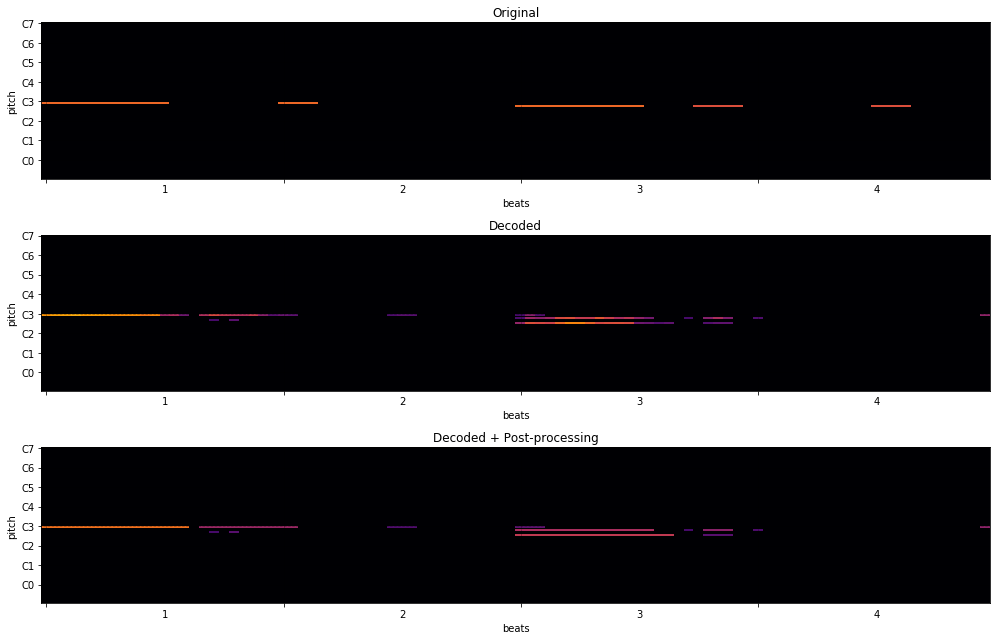

In [192]:
# Plot random input unit along with corresponding next and comp units
unit_index = np.random.randint(len(samples))
sample_unit = samples[unit_index].squeeze()
sample_unit_decoded = samples_decoded[unit_index].squeeze()
sample_unit_decoded_processed = pianoroll_utils.pianoroll_preprocess(sample_unit_decoded, MIN_PITCH, MAX_PITCH)

# Plot comparison
fig, ax = plt.subplots(3,1)
fig.set_size_inches(14, 9, forward=True)
ax[0].set_title('Original')
ax[1].set_title('Decoded')
ax[2].set_title('Decoded + Post-processing')
pianoroll_utils.plot_pianoroll(ax[0], sample_unit, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
pianoroll_utils.plot_pianoroll(ax[1], sample_unit_decoded, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
pianoroll_utils.plot_pianoroll(ax[2], sample_unit_decoded_processed, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Listen to the MIDI files
pianoroll_utils.play_pianoroll(sample_unit, MIN_PITCH, MAX_PITCH, '0')
pianoroll_utils.play_pianoroll(sample_unit_decoded, MIN_PITCH, MAX_PITCH, '1', process=False)
pianoroll_utils.play_pianoroll(sample_unit_decoded_processed, MIN_PITCH, MAX_PITCH, '1')

## Transferring files from remote to local machine

Following [this tutorial](https://cloud.google.com/compute/docs/instances/transfer-files#transfergcloud), using SCP. (Need to have gcloud set up on local machine)
```
gcloud compute scp comper-gpu:<REMOTE_FILEPATH> <LOCAL_FILEPATH>
```

## p5.js

Unforunately this doesn't _just work_. Might need some fiddling, probably not worth it for now.

In [2]:
%%HTML
<script src="https://cdnjs.cloudflare.com/ajax/libs/p5.js/0.6.1/p5.js"></script>

In [3]:
%%javascript

function setup() {
    createCanvas(300,300);
}

function draw() {
    ellipse(width/2, height/2, 100, 100);
}

<IPython.core.display.Javascript object>

### Sequence-to-sequence model test

In [3]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

num_encoder_tokens = 96
num_decoder_tokens = 96
latent_dim = 100

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 96)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None, 96)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 100), (None, 78800       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 100),  78800       input_3[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [ ]:
# Run training
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)